In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re

from keras.models import Model
from keras.layers import Bidirectional, Dense, Input, Dropout, LSTM, Activation, TimeDistributed, BatchNormalization, concatenate, Concatenate
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.initializers import glorot_uniform
from sklearn.model_selection import train_test_split

from itertools import chain

from grail_data_utils import *

%matplotlib inline

np.random.seed(1)

Using TensorFlow backend.


In [2]:
# entire corpus
X, Y1, Y2, Z, vocabulary, vnorm, partsofspeech1, partsofspeech2, superset, maxLen = read_maxentdata('m2.txt')

In [3]:
numClasses = len(partsofspeech2)+1
numSuperClasses = len(superset)+1

print()
print("Longest sentence      : ", maxLen)
print("Number of words       : ", len(vocabulary))
print("Number of norm. words : ", len(vnorm))
print("Number of POS tags    : ", numClasses)
print("Number of supertags   : ", numSuperClasses)



Longest sentence      :  266
Number of words       :  30300
Number of norm. words :  28223
Number of POS tags    :  32
Number of supertags   :  891


In [4]:
# split the training data into the standard 60% train, 20% dev, 20% test 
X_train, X_testdev, Y_train, Y_testdev = train_test_split(X, Y2, test_size=0.4)
X_test, X_dev, Y_test, Y_dev = train_test_split(X_testdev, Y_testdev, test_size=0.5)
print("Train: ", X_train.shape)
print("Test:  ", X_test.shape)
print("Dev:   ", X_dev.shape)


Train:  (9449,)
Test:   (3150,)
Dev:    (3150,)


In [5]:

def get_features(string, cat):
    fset = set()

    if (cat == "v"):
        m0 = re.search(r"<(.*)>", string)
        if m0 is not None:
            for item in m0.group(1).split(','):
                fset.add(item)

    m1 = re.search(r"cat=(.*?)[,\]]", string)
    if m1 is not None:
        fset.add(m1.group(1))

    for m2 in re.findall(r"@(.*?)[,\]]", string):
        if not (m2 == "e"):
            fset.add(m2)
    return fset
  

In [6]:
possessive_features = set(['p_P1s', 'p_P2s', 'p_P3s', 'p_P1p', 'p_P2p', 'p_P3p',\
                           'fs_P1s', 'fs_P2s', 'fs_P3s',\
                           's_P1s', 's_P2s', 's_P3s', 's_P1p', 's_P2p', 's_P3p'])

verb_inflection_features = set(['P1s', 'P12s', 'P2s', 'P3s', 'P1p', 'P2p', 'P3p',\
                                'J1s', 'J12s', 'J2s', 'J3s', 'J1p', 'J2p', 'J3p',\
                                'T1s', 'T2s', 'T3s', 'T1p', 'T2p', 'T3p',\
                                'F1s', 'F2s', 'F3s', 'F1p', 'F2p', 'F3p',\
                                'C1s', 'C12s', 'C3s', 'C1p', 'C2p', 'C3p',\
                                'S1s', 'S13s', 'S2s', 'S3s', 'S1p', 'S2p', 'S3p',\
                                #'Y2s', 'Y1p','Y2p', 
                                'G', 'W',\
                                'I1s', 'I12s', 'I3s', 'I1p', 'I2p', 'I3p',\
                                'PS13s', 'PS3','PS2s', 'PS3p',\
                                'PJ12s', 'ST2s',\
                                'K', 'Km', 'Kms', 'Kfs', 'Kmp', 'Kfp'])

inflection_features = set(['ms', 'mp', 'fs', 'fp', '1s', '2s', '3s', '1p', '2p', '3p', '3ms', '3fs', '3mp', '3fp'])

object_map  = { 'Obj:(cla|sn)':'sn', 'Obj:cla|qcompl|scompl|sinf|sn':'qcompl|scompl|sinf|sn',\
             'Obj:cla|scompl|sn':'scompl|sn', 'Obj:cla|de-sinf|sn':'de-sinf|sn',\
             'Obj:sinf':'sinf', 'Obj:(cla|scompl|sn)':'scompl|sn',\
             'Obj:(cla|scompl|sinf|sn)':'scompl|sinf|sn', 'Obj:(cla|seréc|seréfl|sn)':'sn',\
             'Obj:(à-sinf)':'à-sinf', 'Obj:cla|qcompl|scompl|sn':'qcompl|scompl|sn',\
             'Obj:(scompl|sinf)':'scompl|sinf', 'Obj:(cla|pour-sn|sn)':'pour-sn|sn',\
             'Obj:(cla|de-sinf|scompl|sn)':'de-sinf|scompl|sn', 'Obj:cla|scompl|sinf|sn':'scompl|sinf|sn',\
             'Obj:à-sinf':'à-sinf', 'Obj:(cla|de-sinf|sn|à-sinf)':'de-sinf|sn|à-sinf',\
             'Obj:(cla|qcompl|scompl|sn)':'qcompl|scompl|sn', 'Obj:(cla|de-sinf|sn)':'de-sinf|sn',\
             'Obj:de-sinf':'de-sinf', 'Obj:(cla|qcompl|scompl|sn|à-sinf)':'qcompl|scompl|sn|à-sinf',\
             'Obj:(cla|qcompl|scompl|sinf|sn)':'qcompl|scompl|sinf|sn', 'Obj:cla|sn':'sn',\
             'Obj:(cla|de-sinf|qcompl|scompl|sn)':'de-sinf|qcompl|scompl|sn',\
             'Obj:sn':'sn', 'Obj:scompl':'scompl', 'Obj:qcompl':'qcompl', 'Obj:pour-sn':'pour-sn'}


In [54]:
def transform_features(valset):
    features = set()
    for val in valset:
        if val in possessive_features:
            features.add("possessive")
        elif val in verb_inflection_features:
            fts = list(val)
            features = features.union(fts)
        elif val in inflection_features:
            fts = list(val)
            features = features.union(fts)
        elif val == "Obl:en-sn":
            features.add("Obl:(en-sn)")
        elif val == "Att:pour-sa|pour-sn":
            features.add("Att:(pour-sa|pour-sn)")
        elif val.startswith("Suj:"):
            None
        elif val == "imperative" or val == "pers":
            None
        elif val.startswith("Objà:"):
            features.add("Objà")
        elif val.startswith("Objde:"):
            features.add("Objde")
        elif val.startswith("Obj:"):
            tmp = object_map[val]
            lst = tmp.split('|')
            for l in lst:
                features.add("Obj:" + l)
        else:
            features.add(val)
            
    return features

In [55]:

def read_lefff(file):
    vocabulary = set()
    tags = set()
    word_pos_map = {}
    max_word_len = 0
    with open(file, 'r') as f:
        for line in f:
            line = line.strip().split("\t")
            w = line[0]
            w = w.replace("æ", "ae")
            w = w.replace("œ", "oe")
            w = w.replace("-_", "-")
            word_len = len(w)
            if (word_len > max_word_len):
                max_word_len = word_len
            wlist = w.split()
            if (len(wlist) == 2):
                w = wlist[0]
                nextfeat == None
                if (wlist[1]).startswith("qu'"):
                    nextfeat = "Next:que"
                if (wlist[1]).startswith("que "):
                    nextfeat = "Next:que"
                if (wlist[1] == 'que'):
                    nextfeat = "Next:que"
                if (wlist[1]).startswith("d'"):
                    nextfeat = "Next:de"
                if (wlist[1]).startswith("de "):
                    nextfeat = "Next:de"
                if (wlist[1] == 'de'):
                    nextfeat = "Next:de"
                if (wlist[1]).startswith("à "):
                    nextfeat = "Next:à"
                if (wlist[1] == 'à'):
                    nextfeat = "Next:à"
                if (wlist[1] == 'priori'):
                    nextfeat = "Next:priori"
            elif (len(wlist) == 1):
                nextfeat = None
                
            if (w[0].find("_") == -1 and (len(wlist) == 1) or ((len(wlist) ==2) and (nextfeat is not None))):
                if (w == "c'est-à-dire"):
                    w = "est-à-dire"
                    nextfeat = "Prev:ce"
                pos = line[2]
                features = line[3]
                vocabulary.add(w)
                valset = word_pos_map.get(w)
                if valset is None:
                    valset = set()
                valset.add(pos)
                fts = get_features(features, pos)
                valset = valset.union(fts)
                if nextfeat is not None:
                    valset.add(nextfeat)
                valset = transform_features(valset)
                word_pos_map[w] = valset

    for w in ['capella', 'contratio', 'fortiori', 'latere', 'minima', 'posteriori',  'priori']:
        word_pos_map[w] = set(['priori'])
                
    for key in iter(word_pos_map.keys()):
        word_pos_map[key] = frozenset(word_pos_map[key])
        
    for val in iter(word_pos_map.values()):
        tags.add(val)
    
    word_pos_map["un"] = frozenset({'nc', 'det', 's', 'pro', 'm'})
    word_pos_map["la"] = frozenset({'s', 'cla', '3', 'f', 'det'})
    return vocabulary, tags, word_pos_map, max_word_len


In [56]:
v, t, wpm, maxWordLen = read_lefff('lefff-ext-3.0.txt')

In [57]:
print(maxWordLen)
#print(t)

60


In [58]:
print(len(t))

9263


In [59]:
print(wpm["Jean"])

frozenset({'m', 'f', 's', 'hum', 'np'})


In [60]:
print(wpm["est"])

frozenset({'P', 'fêtre', 'm', 'v', 'adj', '3', 's', 'AttSuj', 'nc', 'Att:(sa|à-sinf|à-sn)', 'Att:(de-sinf|scompl|sn)', 'auxEtre'})


In [61]:
print(wpm["été"])

frozenset({'m', 'fêtre', 'v', 'active', 's', 'AttSuj', 'nc', 'Att:(sa|à-sinf|à-sn)', 'Att:(de-sinf|scompl|sn)', 'K', 'auxEtre'})


In [62]:
print(wpm["était"])

frozenset({'fêtre', 'v', '3', 's', 'AttSuj', 'Att:(sa|à-sinf|à-sn)', 'Att:(de-sinf|scompl|sn)', 'auxEtre', 'I'})


In [63]:
print(wpm["faut"])

frozenset({'P', 'v', 'impers', 'Obj:sinf', 'Objà', 'CompSubj', 'Obj:scompl', '3', 'Obj:sn', 's'})


In [64]:
print(wpm["mange"])

frozenset({'Y2s', 'P', 'v', '3', '1', 'Obj:sn', 's', 'S'})


In [65]:
print(wpm["que"])

frozenset({'que_restr', 'prel', 'pri', 'pro_acc', 'que'})


In [66]:
print(wpm["qu'"])

frozenset({'que_restr', 'prel', 'pri', 'pro_acc', 'que'})


In [20]:
print(wpm["la"])
print(wpm["le"])
print(wpm["l'"])
print(wpm["les"])

frozenset({'s', 'cla', '3', 'det', 'f'})
frozenset({'m', 's', 'cla', '3', 'det'})
frozenset({'m', 's', 'cla', '3', 'det', 'f'})
frozenset({'cla', '3', 'det', 'p'})


In [21]:
print(wpm["un"])
print(wpm["une"])

frozenset({'m', 's', 'nc', 'pro', 'det'})
frozenset({'s', 'nc', 'pro', 'det', 'f'})


In [22]:
print(len(v))

405055


In [67]:
fset = set()
for frozen in t:
    for f in frozen:
        fset.add(f)
print(fset)
print(len(fset))
outFeatures = len(fset)+1

{'cld', 'Att:de-sa|de-sn', 'CtrlObjàObj', 'négatif', 'Obl:(à-sinf)', 'Obl:(après-sn)', 'csu', 'Att:(sa|sn)', 'pro_loc', 'W', 'Att:(sinf)', 'advneg', 'weekday', 'Obl:(pour-sn)', 'coo', 'T', 'adjPref', 'cla', 'clneg', 'Obl2:(sur-sn)', 'pseudo-y', 'Obl:(par-sn)', 'CtrlSujAtt', 'pro_nom', 'Objde', 'que_restr', 'pri', 'Next:à', 'Dloc:(de-sn)', 'Loc:(sur-sn)', 'clar', 'parentf', 'Obj:scompl', '1', 'Obl:(contre-sn|sur-sn)', 'clr', 'se_moyen', 'Att:(de-sinf|scompl|sn)', 'Obl:(sur-sn)', 'Y2p', 'priori', 'Att:(sn)', 'nc', 'Att:sa|sinf|sn', 'Att:y|à-sinf', 'Obl:(avec-sn)', 'pseudo-en_possible', 'Att:(sa|sinf|sn)', 'Loc:(à-sn)', 'Next:priori', 'pron', 'cll', 'adv', 'CtrlObjàSuj', 'CtrlSujObjde', 'K', 'advp', 'CtrlObjAtt', 'advm', 'Loc:loc-sn|y', 'CompInd', 'm', 'CtrlObjàObl', 'prep', 'advPref', 'CompSubj', 'CtrlSujObj', 'Obj:sn', 'n', 'cldr', 's', 'cln', 'auxEtre', '2', 'f', 'time', 'Objà', 'auxAvoir', 'Obl:(sinf)', 'Obl:(pour-sinf|sinf)', 'active', 'Loc:(dans-sn|y|à-sinf)', 'CtrlSujObl', 'Loc:(lo

In [68]:
feature_to_integer, integer_to_feature = indexify(fset)

In [69]:
print(X[0])
print(integer_to_feature[140])

['Lyonnaise-Dumez', 'vient', "d'", 'hispaniser', 'sa', 'filiale', 'espagnole', 'et', "d'", 'étendre', 'ses', 'participations', 'en', 'Espagne', ',', 'tout', 'en', 'resserrant', 'ses', 'liens', 'avec', 'la', 'Caixa', ',', 'première', 'caisse', "d'", 'épargne', 'espagnole', 'et', "l'", 'un', 'des', 'premiers', 'établissements', 'financiers', 'de', 'la', 'péninsule', 'ibérique', ',', 'à', 'laquelle', 'elle', 'est', 'liée', 'depuis', 'longtemps', 'dans', 'la', 'Société', 'générale', 'des', 'eaux', 'de', 'Barcelone', '(', 'SGAB', ')', ',', 'premier', 'groupe', 'espagnol', 'de', 'services', '(', 'la', 'Caixa', 'détient', 'aussi', '2', '%', 'du', 'capital', 'de', 'Lyonnaise-Dumez', ')', '.']
loc


In [70]:
def get_characters(vocabulary):

    characters = set(['^', 'Û', '³', 'Ê', '<BOS>', '<BOW>', '<EOW>', '<EOS>', '<UNK>', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
    for word in vocabulary:
        clist = list(word)
        for char in clist:
            characters.add(char)
    
    remove = set(['|', '«', '»', 'µ', '§', 'þ', 'ø', '_', '¯', 'ð', 'æ', '~', '©', '@', '~'])
    
    return characters - remove

In [71]:
characters = get_characters(v)
print(characters)
print(len(characters))

maxChars = len(characters)

character_to_integer, integer_to_character = indexify(characters)

{'î', '!', '<EOW>', 'ï', 'W', '<EOS>', 'T', 'ö', 'i', '<BOS>', 'å', '.', '%', '³', 'M', 'a', '±', 'E', 'Ç', '<BOW>', 'ü', '7', 'à', 'Z', 'L', '>', '8', ',', 'r', 'N', 'ä', '&', '1', 'ê', 'ù', '(', 'X', ']', '"', 'j', '0', 'K', 'A', 'º', 'È', 'm', 'Ê', 'n', 's', 'é', 'x', 'q', '2', 'f', 'e', 'Q', '*', 'Á', '=', '<UNK>', 'C', 'P', '^', '5', '<', 't', 'ñ', '?', ')', 'ó', 'ë', 'À', 'R', 'b', 'í', "'", ':', 'y', 'l', 'ô', 'Y', 'I', '²', '+', 'õ', 'd', 'ò', '-', '°', '4', 'o', '½', 'w', 'è', 'D', 'U', 'z', '/', 'V', 'k', 'â', 'Å', 'Î', '9', 'u', 'v', 'É', '$', 'ú', 'p', 'h', 'ç', 'ì', 'H', 'G', 'û', 'F', 'á', 'Û', 'B', 'S', '[', '3', 'J', 'O', ';', 'g', '6', 'ã', 'c'}
130


In [72]:
mapping = {}

mapping["="] = set(['math', 'infix'])
mapping["<"] = set(['math', 'infix'])
mapping[">"] = set(['math', 'infix'])


mapping["+"] = set(['math', 'infix'])
mapping["*"] = set(['math', 'infix'])
mapping["±"] = set(['math', 'prefix'])
mapping["°"] = set(['math', 'postfix'])
mapping["º"] = set(['math', 'postfix'])
mapping["²"] = set(['math', 'postfix'])
mapping["³"] = set(['math', 'postfix'])



mapping["0"] = set(['9'])
mapping["1"] = set(['9'])
mapping["2"] = set(['9'])
mapping["3"] = set(['9'])
mapping["4"] = set(['9'])
mapping["5"] = set(['9'])
mapping["6"] = set(['9'])
mapping["7"] = set(['9'])
mapping["8"] = set(['9'])
mapping["½"] = set(['9'])

mapping["A"] = set(['a', 'maj'])
mapping["B"] = set(['b', 'maj'])
mapping["C"] = set(['c', 'maj'])
mapping["D"] = set(['d', 'maj'])
mapping["E"] = set(['e', 'maj'])
mapping["F"] = set(['f', 'maj'])
mapping["G"] = set(['g', 'maj'])
mapping["H"] = set(['h', 'maj'])
mapping["I"] = set(['i', 'maj'])
mapping["J"] = set(['j', 'maj'])
mapping["K"] = set(['k', 'maj'])
mapping["L"] = set(['l', 'maj'])
mapping["M"] = set(['m', 'maj'])
mapping["N"] = set(['n', 'maj'])
mapping["O"] = set(['o', 'maj'])
mapping["P"] = set(['p', 'maj'])
mapping["Q"] = set(['q', 'maj'])
mapping["R"] = set(['r', 'maj'])
mapping["S"] = set(['s', 'maj'])
mapping["T"] = set(['t', 'maj'])
mapping["U"] = set(['u', 'maj'])
mapping["V"] = set(['v', 'maj'])
mapping["W"] = set(['w', 'maj'])
mapping["X"] = set(['x', 'maj'])
mapping["Y"] = set(['y', 'maj'])
mapping["Z"] = set(['z', 'maj'])

mapping["á"] = set(['a', 'aigu'])
mapping["à"] = set(['a', 'grave'])
mapping["ä"] = set(['a', 'uml'])
mapping["â"] = set(['a', 'circ'])
mapping["ã"] = set(['a', 'tilde'])
mapping["å"] = set(['a'])

mapping["ç"] = set(['c', 'cedil'])

mapping["é"] = set(['e', 'aigu'])
mapping["è"] = set(['e', 'grave'])
mapping["ê"] = set(['e', 'circ'])
mapping["ë"] = set(['e', 'uml'])


mapping["ï"] = set(['i', 'uml'])
mapping["í"] = set(['i', 'aigu'])
mapping["î"] = set(['i', 'circ'])
mapping["ì"] = set(['i', 'grave'])

mapping["ñ"] = set(['n', 'tilde'])

mapping["ö"] = set(['o', 'uml'])
mapping["ó"] = set(['o', 'aigu'])
mapping["õ"] = set(['o', 'tilde'])
mapping["ô"] = set(['o', 'circ'])
mapping["ò"] = set(['o', 'grave'])
mapping["ò"] = set(['o', 'grave'])


mapping["û"] = set(['u', 'circ'])
mapping["ú"] = set(['u', 'aigu'])
mapping["ù"] = set(['u', 'grave'])
mapping["ü"] = set(['u', 'uml'])

mapping["Á"] = set(['a', 'maj', 'aigu'])
mapping["À"] = set(['a', 'maj', 'grave'])
mapping["Å"] = set(['a', 'maj'])

mapping["Ç"] = set(['c', 'maj', 'cedil'])

mapping["È"] = set(['e', 'maj', 'grave'])
mapping["É"] = set(['e', 'maj', 'aigu'])
mapping["Ê"] = set(['e', 'maj', 'circ']) 

mapping["Î"] = set(['i', 'maj', 'circ'])

mapping["Û"] = set(['u', 'maj', 'circ'])



In [73]:
def compute_symset (characters, mapping):
    symset = set()
    for c in characters:
        try:
            syms = mapping[c]
            symset = symset.union(syms)
        except:
            symset.add(c)
    return symset

In [74]:
sset = compute_symset(characters, mapping)
print(sset)

maxCharFeat = len(sset)+1
print(len(sset))

print(mapping['+'])

{'!', 'u', '<EOW>', '9', 'j', '^', 'tilde', 'v', 't', 'cedil', '$', '/', '?', ')', 'k', 'infix', 'p', 'h', '"', 'b', 'circ', 'maj', '<EOS>', "'", 'i', '<BOS>', ':', 'y', 'l', 'postfix', '.', '%', 'a', 'uml', 'm', '<BOW>', 'd', 'aigu', 'n', 's', 'x', 'q', ',', 'r', 'f', '[', 'math', 'prefix', '-', 'o', '&', 'w', ';', 'e', '(', 'g', 'grave', 'z', '<UNK>', ']', 'c'}
61
{'math', 'infix'}


In [75]:
def char_to_charfeatures (char, mpg, symbset):
    try:
        feats = mpg[char]
    except:
        if (char in symbset):
            feats = set([char])
        else:
            feats = set(['<UNK>'])
    
    return feats

In [76]:
char_to_charfeatures("A", mapping, sset)

{'a', 'maj'}

In [77]:
charf_to_integer, integer_to_charf = indexify(sset)

In [78]:
charf_to_integer.keys()

dict_keys(['!', 'u', '<EOW>', '9', 'j', '^', 'tilde', 'v', 't', 'cedil', '$', '/', '?', ')', 'k', 'infix', 'p', 'h', '"', 'b', 'circ', 'maj', '<EOS>', "'", 'i', '<BOS>', ':', 'y', 'l', 'postfix', '.', '%', 'a', 'uml', 'm', '<BOW>', 'd', 'aigu', 'n', 's', 'x', 'q', ',', 'r', 'f', '[', 'math', 'prefix', '-', 'o', '&', 'w', ';', 'e', '(', 'g', 'grave', 'z', '<UNK>', ']', 'c'])

In [79]:
def char_to_one_hot(char, mpg, c_to_in, symbset, mcf):
    fset = char_to_charfeatures(char, mpg, symbset)
    numf = len(fset)
    
    tmp = np.zeros(numf)
    index = 0
    for item in fset:
        tmp[index] = c_to_in[item]
        index = index + 1
    Y = to_categorical(tmp, mcf)
    return np.sum(Y,axis=0)
   

In [80]:
Y0 = char_to_one_hot("A", mapping, charf_to_integer, sset, maxCharFeat)

print(Y0)


[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.]


In [81]:
transform = np.zeros((maxChars+1, maxCharFeat))
for char, i in character_to_integer.items():
    transform[i] = char_to_one_hot(char, mapping, charf_to_integer, sset, maxCharFeat)
    
np.shape(transform)

(131, 62)

In [82]:
def word_to_one_hot(word, mpg, c_to_in, symbset, mcf, bos, eos):
    ls = list(word)
    length = len(ls)+2
    end = length - 1
    Y = np.zeros((length,mcf))
    if bos:
        Y[0] = char_to_one_hot('<BOS>', mpg, c_to_in, symbset, mcf)
    else:    
        Y[0] = char_to_one_hot('<BOW>', mpg, c_to_in, symbset, mcf)
    if eos:
        Y[end] = char_to_one_hot('<EOS>', mpg, c_to_in, symbset, mcf)
    else:    
        Y[end] = char_to_one_hot('<EOW>', mpg, c_to_in, symbset, mcf)

    for i in range(0,end-1):
        Y[i+1] = char_to_one_hot(ls[i], mpg, c_to_in, symbset, mcf)
        
    return Y

In [83]:
Jean = word_to_one_hot('Jean', mapping, charf_to_integer, sset, maxCharFeat, True, True)
print(np.shape(Jean))
print(Jean)

(6, 62)
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.

In [84]:
totalWords = 0
for i in range(len(X_train)):
    for j in range(len(X_train[i])):
        totalWords = totalWords + 1
  
print(totalWords)

264432


In [85]:
def compute_total_words(word_matrix):
  
    tw = 0
    
    for i in range(len(word_matrix)):
        for j in range(len(word_matrix[i])):
             tw = tw + 1

    return tw


In [86]:
def word_matrix_to_charint_matrix(word_matrix, max_chars):
 
    total_words = compute_total_words(word_matrix)
    
    X_charint = np.zeros((total_words,max_chars))
    
    xindex = 0

    # iterate over sentences in input matrix
    for i in range(len(word_matrix)):
        end = len(word_matrix[i])
        # iterater over words in sentences
        for j in range(len(word_matrix[i])):
            charslist = list(word_matrix[i][j])
            # add beginning/end of word/sentence tags to word
            if (j == 0):
                X_charint[xindex][0] = character_to_integer['<BOS>']
            else:
                X_charint[xindex][0] = character_to_integer['<BOW>']
            if (j == end-1):
                X_charint[xindex][len(charslist)+1] = character_to_integer['<EOS>']
            else:
                X_charint[xindex][len(charslist)+1] = character_to_integer['<EOW>']
            for c in range(len(charslist)):
                d = c + 1
                char = charslist[c]
                try:
                    X_charint[xindex][d] = character_to_integer[char]
                except:
                    # warn when unknown character is encountered
                    print("Unknown character: ", end='')
                    print(i, end=' ')
                    print(charslist)
            # increase word counter
            xindex = xindex + 1
    return X_charint

In [87]:
X_charint_input = word_matrix_to_charint_matrix(X_train, maxChars)

In [88]:
print(np.shape(X_charint_input))
print(X_charint_input[5])

(264432, 130)
[ 20.  28.   3.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]


In [89]:
print(X_train[397])
print(character_to_integer['U'])

['-', '^', 'Reuters', 'Doctoring', 'Photos', 'from', 'Beirut', '?']
96


In [90]:
# compensate for some missing words in lefff

def outword_mapping(word):
    lword = word.lower()
    if lword == "auquel":
        return set(['à', 'lequel'])
    if lword == "auxquels":
        return set(['à', 'lesquels'])
    if lword == "auxquelles":
        return set(['à', 'lesquelles'])
    if lword == "aux":
        return set(['à', 'les'])
    if lword == "duquel":
        return set(['de', 'lequel'])
    if lword == "desquels":
        return set(['des', 'lesquels'])
    if lword == "desquelles":
        return set(['des', 'lesquelles'])
    if lword == "des":
         return set(['de', 'les'])
    if lword == "au":
        return set(['à', 'le'])
    if lword == "du":
         return set(['de', 'le'])
    if lword == "deçà":
         return set(['dessous'])
    if lword == "m2" or lword == "m3" or lword == "m²" or lword == "m³":
        return set(['mètre', 'mètres'])
    if lword == "cm2" or lword == "cm3" or lword == "cm²" or lword == "cm³":
        return set(['centimètre', 'centimètres'])
    if word == "Etat":
         return set(["état"])
    if len(word) == 1 and word.isupper:
        return set(['Alpha'])
    if is_numeral(word):
        return set(["dix-sept"])
    if word == "CEE":
        return set(['communauté'])
    if word == "CNRS":
        return set(['centre'])
    if word == "CRS":
        return set(['compagnie'])
    if word == "CNPF":
        return set(['conseil'])
    if word == "CSA":
        return set(['conseil'])
    if word == "EDF":
        return set(['électricité'])
    if word == "ANPE":
        return set(['agence'])
    if word == "ONG" or word == "ONU":
        return set(['organisation'])
    if word == "OPA":
        return set(['offre'])
    if word == "PEA" or word == "PEL":
        return set(['plan'])
    if word == "SNCF":
        return set(['société'])
    if word == "AOC":
        return set(['appelation'])
    if word == "ALENA":
        return set(['accord'])
    if word == "ASSEDIC":
        return set(['association'])
    if word == "PIB":
        return set(['produit'])
    if word == "SMIC":
        return set(['salaire'])
    if word == "RPR":
        return set(['rassemblement'])
    if word == "HLM":
        return set(['habitation'])
    if word == "INSEE":
        return set(['institute'])
    if word == "FMI":
        return set(['fonds'])
    if word == "RFA":
        return set(['république'])
    return set([word])
       

In [91]:
def wordf_to_one_hot(word, outword_mapping, wpm, f_to_in, fset, outf):
    wordset = outword_mapping(word)
    featureset = set()
    for word in wordset:
        if word in wpm.keys():
            featureset = featureset.union(wpm[word])
        else:
            wordl = word.lower()
            if wordl in wpm.keys():
                featureset = featureset.union(wpm[wordl])
            else:
                print("Unknown: ", word)
                featureset = set()
            
    length = len(featureset)
#    Y = np.zeros((length,outf))

    i = 0
    tmp = np.zeros(len(featureset))
    for f in featureset:
        tmp[i] = f_to_in[f]
        i = i + 1
    Y = to_categorical(tmp, outf)

    return np.sum(Y,axis=0)

In [92]:
def normalize_capitals(word):
    word = word.replace("É", "E")
    word = word.replace("Î", "I")
        

In [93]:
vector = wordf_to_one_hot("aux", outword_mapping, wpm, feature_to_integer, fset, outFeatures)
print(np.shape(vector))
print(vector)
print(vector[0])

(172,)
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.
  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  1.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  1.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
0.0


In [94]:
print(X_train[0][0])
vec = wordf_to_one_hot(X_train[0][0], outword_mapping, wpm, feature_to_integer, fset, outFeatures)
print(vec)

Des
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]


In [95]:
def compute_word_targets(X, outword_mapping, wpm, feature_to_integer, fset, outFeatures):

    total_words = compute_total_words(X)
    Y = np.zeros((total_words,outFeatures))

    yindex = 0

    for i in range(len(X)):
        for j in range(len(X[i])):
            Y[yindex] = wordf_to_one_hot(X[i][j], outword_mapping, wpm, feature_to_integer, fset, outFeatures)
            yindex = yindex + 1

    return Y

In [96]:
Y_train = compute_word_targets(X_train, outword_mapping, wpm, feature_to_integer, fset, outFeatures)

Unknown:  CBV
Unknown:  Guintoli
Unknown:  ÉTATS-UNIS
Unknown:  Popi
Unknown:  Bayard
Unknown:  HLM
Unknown:  TVA
Unknown:  Doubin
Unknown:  Pétriat
Unknown:  FNAC
Unknown:  Ruymbeke
Unknown:  BCCI
Unknown:  Mahfouz
Unknown:  bank
Unknown:  Chamard
Unknown:  RPR
Unknown:  UDF
Unknown:  UDC
Unknown:  Pronasol
Unknown:  Bundesbank
Unknown:  UNIM
Unknown:  Schlesinger
Unknown:  Bundesbank
Unknown:  PS
Unknown:  Balmary
Unknown:  OCDE
Unknown:  SME
Unknown:  PNB
Unknown:  RPR
Unknown:  UDF
Unknown:  rétrocommissions
Unknown:  Strauss-Kahn
Unknown:  CNPF
Unknown:  UPA
Unknown:  RMI
Unknown:  PAP
Unknown:  Lodz
Unknown:  Bydgoszcz
Unknown:  Wroclaw
Unknown:  Zielona-Gora
Unknown:  Szczecin
Unknown:  Bérégovoy
Unknown:  Gomez
Unknown:  Eisswein
Unknown:  Thomson
Unknown:  Elettrofinanziaria
Unknown:  spa
Unknown:  Elfi
Unknown:  Kosovo
Unknown:  Bonn
Unknown:  Staedelin
Unknown:  PTT
Unknown:  Olszewski
Unknown:  Rubik's
Unknown:  Elf
Unknown:  Thomson
Unknown:  CSF
Unknown:  Elf
Unknown:  Ga

Unknown:  Pentland
Unknown:  BTF
Unknown:  Gbm.H
Unknown:  BTF
Unknown:  Pentland
Unknown:  Clinvest
Unknown:  AGF
Unknown:  Worms
Unknown:  BNP
Unknown:  Banexi
Unknown:  BTF
Unknown:  Gbm.H
Unknown:  Sochaux-Montbéliard
Unknown:  Louise-Yvonne
Unknown:  Casetta
Unknown:  RPR
Unknown:  Curien
Unknown:  Mellick
Unknown:  Bull
Unknown:  Nec
Unknown:  GPL
Unknown:  AEG
Unknown:  Lagardère
Unknown:  TF
Unknown:  zig-Zag
Unknown:  Bouygues
Unknown:  DEFICIT
Unknown:  UNEDIC
Unknown:  RDA
Unknown:  Joffre
Unknown:  Who's
Unknown:  next
Unknown:  SCA
Unknown:  SCA
Unknown:  Pelège
Unknown:  Electronique
Unknown:  Bundesbank
Unknown:  CAC
Unknown:  Sirven
Unknown:  Elf
Unknown:  Dumas
Unknown:  L.
Unknown:  C.
Unknown:  Waïkiki
Unknown:  Guigou
Unknown:  MFI
Unknown:  Furniture
Unknown:  group
Unknown:  Bongrain
Unknown:  ULN
Unknown:  Besnier
Unknown:  RVI
Unknown:  Mercedes-Benz
Unknown:  Eltsine
Unknown:  Fath
Unknown:  OLP
Unknown:  Zeid
Unknown:  Wehbé
Unknown:  OLP
Unknown:  Joumblatt
U

Unknown:  Azeglio
Unknown:  Ciampi
Unknown:  RDA
Unknown:  Deutscher
Unknown:  Fernsehfunk
Unknown:  DFF
Unknown:  Ciba
Unknown:  Duluth
Unknown:  CO2
Unknown:  Kia
Unknown:  CNJA
Unknown:  PAC
Unknown:  Lucette
Unknown:  Monti
Unknown:  GEC
Unknown:  Plessey
Unknown:  GPT
Unknown:  GEC
Unknown:  Plessey
Unknown:  Telecommunications
Unknown:  Parretti
Unknown:  Metro
Unknown:  Goldwyn
Unknown:  Mayer
Unknown:  MGM
Unknown:  Ducros
Unknown:  Foremost
Unknown:  Oliveira
Unknown:  ROME
Unknown:  stockeurs
Unknown:  Angiox
Unknown:  ICP
Unknown:  Belfond
Unknown:  Talamon
Unknown:  Lacharrière
Unknown:  Sontag
Unknown:  Coudari
Unknown:  Malvy
Unknown:  Malev
Unknown:  AVU
Unknown:  Abou
Unknown:  Zouhri
Unknown:  Lebègue
Unknown:  BNP
Unknown:  AGF
Unknown:  GAN
Unknown:  Heilbronner
Unknown:  SAGEM
Unknown:  Bunuel
Unknown:  GTM-entrepose
Unknown:  Reveglio
Unknown:  RMI
Unknown:  Milred
Unknown:  länder
Unknown:  Thomson-CSF
Unknown:  Briand
Unknown:  Balladur
Unknown:  OPEP
Unknown:  P

Unknown:  Saint-Pétersbourg
Unknown:  Nijni-Novgorod
Unknown:  Saratov
Unknown:  Tcheliabinsk
Unknown:  Louvie
Unknown:  RPR
Unknown:  fontion
Unknown:  OTAN
Unknown:  Albright
Unknown:  rétrocommissions
Unknown:  Wang
Unknown:  Delors
Unknown:  Gaulle
Unknown:  Pompidou
Unknown:  Wang
Unknown:  Viard
Unknown:  CEE
Unknown:  Trotski
Unknown:  Bercy
Unknown:  ICP
Unknown:  stent
Unknown:  abciximab
Unknown:  Mesle
Unknown:  Rivkin
Unknown:  Béart
Unknown:  ejido
Unknown:  livre-fleuve
Unknown:  secteurs-clés
Unknown:  Gorbatchev
Unknown:  HARCOURT
Unknown:  Volkswagen
Unknown:  Volkswagen
Unknown:  FS
Unknown:  COBAS
Unknown:  CEE
Unknown:  FMI
Unknown:  Tintin
Unknown:  Lenoir
Unknown:  Devillers
Unknown:  Manhattan
Unknown:  Bank
Unknown:  Citibank
Unknown:  Sedgwick
Unknown:  Financial
Unknown:  Sedgwick
Unknown:  SFS
Unknown:  Nestlé
Unknown:  Elifas
Unknown:  ruralité
Unknown:  maritimité
Unknown:  Drian
Unknown:  Delors
Unknown:  Lagardère
Unknown:  Stern
Unknown:  Northern
Unknow

Unknown:  Mc.
Unknown:  Donnell
Unknown:  J.-F.-Kennedy
Unknown:  Blum
Unknown:  sous-évaluation
Unknown:  ACOSS
Unknown:  Dassler
Unknown:  Exor
Unknown:  Ominco
Unknown:  SBF
Unknown:  Pointe-des-Galets
Unknown:  Tamatave
Unknown:  Ruymbeke
Unknown:  CD-ROM
Unknown:  Clearstream
Unknown:  Bagnères
Unknown:  Bénasque
Unknown:  UER
Unknown:  Euronews
Unknown:  UTA
Unknown:  ICL
Unknown:  Fujitsu
Unknown:  Méry
Unknown:  Twain
Unknown:  Denormandie
Unknown:  Edinter
Unknown:  Guéno
Unknown:  Pasqua
Unknown:  RTL
Unknown:  Duport
Unknown:  CPI
Unknown:  Vilaseca
Unknown:  Korauto
Unknown:  Bourget
Unknown:  campo
Unknown:  roues-pelles
Unknown:  Ruymbeke
Unknown:  Xavière
Unknown:  Simeoni
Unknown:  Talancé
Unknown:  CCSDN
Unknown:  Claude-Annick
Unknown:  Tissot
Unknown:  Chugbo
Unknown:  Torre
Unknown:  SAR
Unknown:  Poullain
Unknown:  Méry
Unknown:  RPR
Unknown:  Ynetnews
Unknown:  Soum
Unknown:  Aspè
Unknown:  Di
Unknown:  Rupo
Unknown:  CNTS
Unknown:  ULN
Unknown:  Smith
Unknown:  S

Unknown:  Limbourg
Unknown:  Stoclet
Unknown:  vidéosphère
Unknown:  graphosphère
Unknown:  logosphère
Unknown:  Debray
Unknown:  Eysymontt
Unknown:  Pilkington
Unknown:  co-entreprise
Unknown:  Pilkington
Unknown:  Sandoglass
Unknown:  SP
Unknown:  OPEP
Unknown:  CISL
Unknown:  Kleinwort
Unknown:  Peake
Unknown:  BNP
Unknown:  Kaske
Unknown:  Bf.G.
Unknown:  Milutinovic
Unknown:  TPI
Unknown:  Scheveningen
Unknown:  Haye
Unknown:  FMI
Unknown:  Abidjan
Unknown:  Reuter
Unknown:  Barrère-Maurisson
Unknown:  PUF
Unknown:  F.
Unknown:  Saurer-Diederichs
Unknown:  Aquamot
Unknown:  Asie-Pacifique
Unknown:  Renon
Unknown:  Jawaharlal
Unknown:  Nehru
Unknown:  Bandoung
Unknown:  air-bag
Unknown:  RMI
Unknown:  Rmistes
Unknown:  là-même
Unknown:  sacro-sainte
Unknown:  Mexès
Unknown:  Attali
Unknown:  Airways
Unknown:  Austrian
Unknown:  Airlines
Unknown:  All
Unknown:  Airways
Unknown:  Singapore
Unknown:  Airlines
Unknown:  Girardin
Unknown:  Disneyland
Unknown:  Bérégovoy
Unknown:  Ecurey

Unknown:  qualité-prix
Unknown:  Jean-Noël
Unknown:  Kapferer
Unknown:  HEC
Unknown:  OPCVM
Unknown:  COB
Unknown:  OPCVM
Unknown:  UAP
Unknown:  Bruxelles-Lambert
Unknown:  OAT
Unknown:  BTAN
Unknown:  contrario
Unknown:  Time
Unknown:  Levin
Unknown:  Perraudin
Unknown:  Wang
Unknown:  The
Unknown:  European
Unknown:  COB
Unknown:  LRM
Unknown:  H.
Unknown:  Vuong
Unknown:  Indochine
Unknown:  No.
Unknown:  COMECON
Unknown:  Angiox
Unknown:  bivalirudine
Unknown:  hirudines
Unknown:  Angiox
Unknown:  Genève
Unknown:  Fès
Unknown:  Tchécoslovaquie
Unknown:  UNEDIC
Unknown:  marchandise-étalon
Unknown:  Pasqua
Unknown:  essai-erreur
Unknown:  Tardivon
Unknown:  GAN-CIC
Unknown:  Rausch
Unknown:  Matouk
Unknown:  Khiva
Unknown:  Quilès
Unknown:  Poto-Poto
Unknown:  Philips
Unknown:  Lagardère
Unknown:  CNPF
Unknown:  ARRCO
Unknown:  Eurofed
Unknown:  Eysymontt
Unknown:  CERC
Unknown:  Brust
Unknown:  Buffalo
Unknown:  Grove
Unknown:  ZDS
Unknown:  GSA
Unknown:  Hills
Unknown:  Sri-Lanka

Unknown:  San-Antonio
Unknown:  Aubry
Unknown:  Arthuis
Unknown:  Lang
Unknown:  Schlüter
Unknown:  GATT
Unknown:  TF
Unknown:  NICOLAS
Unknown:  GUILBERT
Unknown:  SGS-Thomson
Unknown:  ASAT
Unknown:  QPL
Unknown:  Kaufhof
Unknown:  Lafayette
Unknown:  Radio-France
Unknown:  RFP
Unknown:  Saint-Just-en-chaussée
Unknown:  RPR
Unknown:  Desmure
Unknown:  RPR
Unknown:  Rivasseau
Unknown:  facteurs-clés
Unknown:  facto
Unknown:  Farnoux
Unknown:  Strauss-Kahn
Unknown:  Echelles
Unknown:  Pohlmann
Unknown:  Hafnia
Unknown:  Eysymontt
Unknown:  Balcerowicz
Unknown:  EDI
Unknown:  Halphen
Unknown:  Marriott
Unknown:  Pasqua
Unknown:  Jospin
Unknown:  RPR
Unknown:  PS
Unknown:  PCF
Unknown:  BP
Unknown:  Statistical
Unknown:  of
Unknown:  world
Unknown:  Energy
Unknown:  Nietzsche
Unknown:  Telecom
Unknown:  Malraux
Unknown:  BRS
Unknown:  Chambéry
Unknown:  Thomson
Unknown:  Thomson
Unknown:  Electronics
Unknown:  PAC
Unknown:  AERIENS
Unknown:  Alitalia
Unknown:  Malev
Unknown:  anglo-germa

Unknown:  Disney
Unknown:  Marrel
Unknown:  sans-emploi
Unknown:  Auto-Éco
Unknown:  Ecosystème
Unknown:  aides-éducateurs
Unknown:  GATT
Unknown:  SFS
Unknown:  non-dits
Unknown:  Quesnot
Unknown:  SFS
Unknown:  Veil
Unknown:  Ponviane
Unknown:  Lazard
Unknown:  australo-argentin
Unknown:  Lagardère
Unknown:  MMB
Unknown:  Arjil
Unknown:  Lagardère
Unknown:  Jospin
Unknown:  Bérégovoy
Unknown:  Brossault
Unknown:  CEE
Unknown:  Delors
Unknown:  CEE
Unknown:  Deutsche
Unknown:  Bank
Unknown:  Bordeaux-Mérignac
Unknown:  Modling
Unknown:  Staline
Unknown:  Zapata
Unknown:  CIVC
Unknown:  appelations
Unknown:  INAO
Unknown:  tourisme-loisirs
Unknown:  BTP
Unknown:  SAE
Unknown:  OFCE
Unknown:  FMI
Unknown:  Alassane
Unknown:  Ouattara
Unknown:  UNEDIC
Unknown:  Disney
Unknown:  BHF
Unknown:  Bank
Unknown:  Berliner
Unknown:  Handels
Unknown:  und
Unknown:  Frankfurter
Unknown:  Bank
Unknown:  Bankers
Unknown:  Elf
Unknown:  Ecco
Unknown:  Forget
Unknown:  Blondelle
Unknown:  Lepicard
Unk

Unknown:  HLM
Unknown:  majorisme
Unknown:  citizen's
Unknown:  CNJA
Unknown:  Agnelli
Unknown:  Exor
Unknown:  FR3
Unknown:  Carnival
Unknown:  Cruise
Unknown:  BRS
Unknown:  Toshiba
Unknown:  Corp
Unknown:  Samsung
Unknown:  Electronics
Unknown:  Co
Unknown:  Ltd
Unknown:  BFCE
Unknown:  Bercy
Unknown:  Trichet
Unknown:  Larosière
Unknown:  Schuller-Maréchal
Unknown:  Bundesbank
Unknown:  Bundesbank
Unknown:  CAC
Unknown:  Smoby
Unknown:  Pechiney
Unknown:  extremis
Unknown:  Pasqua
Unknown:  HLM
Unknown:  Lebègue
Unknown:  CRE
Unknown:  Pelège
Unknown:  Pelège
Unknown:  Pentland
Unknown:  BTF
Unknown:  GmbH
Unknown:  SOFIREM
Unknown:  SME
Unknown:  Isoète
Unknown:  Tardi
Unknown:  Sabouret
Unknown:  PAC
Unknown:  Girard
Unknown:  Lechat
Unknown:  Baur
Unknown:  UDF-PSD
Unknown:  Fokker-100
Unknown:  YLE
Unknown:  CEE
Unknown:  Leibinger
Unknown:  Eiffel
Unknown:  refinancement
Unknown:  ejidos
Unknown:  Lazaro
Unknown:  Cardenas
Unknown:  Wang
Unknown:  INSEE
Unknown:  FMI
Unknown: 

Unknown:  franco-italien
Unknown:  Maxéville
Unknown:  QPL
Unknown:  Limited
Unknown:  NNPC
Unknown:  Darralde
Unknown:  Rousselot
Unknown:  Wall
Unknown:  Street
Unknown:  Lockheed
Unknown:  Kirghiztan
Unknown:  URSSAF
Unknown:  Gascogne
Unknown:  Loira
Unknown:  LRM
Unknown:  Coudanne
Unknown:  SMCI
Unknown:  Pelège
Unknown:  Favier
Unknown:  Tintin
Unknown:  Wilmans
Unknown:  Eltsine
Unknown:  Halphen
Unknown:  Genève
Unknown:  TV
Unknown:  câblo-opérateurs
Unknown:  Lofti
Unknown:  Belhassine
Unknown:  Trichet
Unknown:  Dumas
Unknown:  Outre-Rhin
Unknown:  Iskandar
Unknown:  Safa
Unknown:  Arvor
Unknown:  Pereire
Unknown:  pin's
Unknown:  Modanais
Unknown:  Milken
Unknown:  Drut
Unknown:  Néthou
Unknown:  Maladetta
Unknown:  VOLTA-REDONDA
Unknown:  Kleinwort
Unknown:  Wahl
Unknown:  BNP
Unknown:  Rosès
Unknown:  Reuter
Unknown:  câblo-opérateurs
Unknown:  vidéocommunications
Unknown:  CGV
Unknown:  Perigot
Unknown:  Mayer
Unknown:  Eurotunnel
Unknown:  Thomson
Unknown:  Parretti
Un

Unknown:  Greenwich
Unknown:  Covent
Unknown:  garden
Unknown:  Möllemann
Unknown:  Strauss-Kahn
Unknown:  Kozo
Unknown:  Watanabe
Unknown:  Nikkei
Unknown:  Shinbun
Unknown:  Nikkei
Unknown:  Weekly
Unknown:  hula-hoop
Unknown:  HLM
Unknown:  prince-de-Galles
Unknown:  Duménil
Unknown:  Leblé
Unknown:  prudentiels
Unknown:  Cerus
Unknown:  Genève
Unknown:  Télécom
Unknown:  OCDE
Unknown:  Thouvenel
Unknown:  Wall
Unknown:  Street
Unknown:  Brongniart
Unknown:  Wall
Unknown:  Street
Unknown:  GATT
Unknown:  exploration-production
Unknown:  Reuters
Unknown:  Problem
Unknown:  Weekly
Unknown:  Schuller
Unknown:  Balkany
Unknown:  CNPF
Unknown:  Hayek
Unknown:  Swatchmobile
Unknown:  VVF
Unknown:  OAT
Unknown:  OFCE
Unknown:  Trichet
Unknown:  Mermaz
Unknown:  welfare
Unknown:  state
Unknown:  Etat-providence
Unknown:  Saint-Clément
Unknown:  crédit-relais
Unknown:  ULN
Unknown:  GUF
Unknown:  ultrafrais
Unknown:  Aerospace
Unknown:  Servan
Unknown:  Schreiber
Unknown:  Brégou
Unknown:  O

In [97]:
X_dev_charint = word_matrix_to_charint_matrix(X_dev, maxChars)
Y_dev = compute_word_targets(X_dev, outword_mapping, wpm, feature_to_integer, fset, outFeatures)

Unknown:  ULN
Unknown:  Bongrain
Unknown:  Besnier
Unknown:  RPR-UDF
Unknown:  Marti
Unknown:  Lingesler
Unknown:  popularisation
Unknown:  évènemens
Unknown:  Agnelli
Unknown:  Apollonies
Unknown:  ci
Unknown:  ATT
Unknown:  CSN
Unknown:  OAT
Unknown:  Airways
Unknown:  and
Unknown:  General
Unknown:  Workers
Unknown:  Teulade
Unknown:  Ernewein
Unknown:  dix-mille
Unknown:  CSG
Unknown:  Hurand
Unknown:  Wikipédia
Unknown:  Doubin
Unknown:  BNP
Unknown:  Meciar
Unknown:  Vaclav
Unknown:  Tchécoslovaquie
Unknown:  Bank
Unknown:  of
Unknown:  credit
Unknown:  and
Unknown:  BCCI
Unknown:  Jones
Unknown:  Shakespeare
Unknown:  ejideros
Unknown:  Fortech
Unknown:  Tecphy
Unknown:  Egalement
Unknown:  Castro
Unknown:  Théobald
Unknown:  Cottave
Unknown:  Laffore
Unknown:  Toshiba
Unknown:  OM
Unknown:  IPSN
Unknown:  GRS
Unknown:  primo-accession
Unknown:  ULN
Unknown:  Kohl
Unknown:  Sabouret
Unknown:  cours-plancher
Unknown:  SME
Unknown:  Schumacher
Unknown:  UIC
Unknown:  UFB
Unknown: 

Unknown:  BRGM
Unknown:  Moubarak
Unknown:  Eyadema
Unknown:  Abidjan
Unknown:  FMI
Unknown:  Alenia
Unknown:  Paggio
Unknown:  Rubin
Unknown:  Adidas
Unknown:  Bérégovoy
Unknown:  BFCE
Unknown:  GATT
Unknown:  Méry
Unknown:  Ocalan
Unknown:  Nestlé
Unknown:  Barbieux
Unknown:  Lobry
Unknown:  Exor
Unknown:  COB
Unknown:  OPA
Unknown:  Aegon
Unknown:  NV
Unknown:  San-Francisco
Unknown:  sous-traitée
Unknown:  Naples
Unknown:  Moggi
Unknown:  Northern
Unknown:  Telecom
Unknown:  Wadi
Unknown:  Gitaï
Unknown:  Haïfa
Unknown:  radio-télévision
Unknown:  Michelin
Unknown:  Elf
Unknown:  Eastern
Unknown:  Economic
Unknown:  Olipar
Unknown:  Pandraud
Unknown:  Naftalski
Unknown:  Adnan
Unknown:  Hajj
Unknown:  SNAV
Unknown:  commutant-type
Unknown:  INSEE
Unknown:  SNECMA
Unknown:  CGI
Unknown:  Adidas
Unknown:  PAC
Unknown:  Meisonnier
Unknown:  Juventus
Unknown:  Fiorentina
Unknown:  Lazio
Unknown:  Jaans
Unknown:  IML
Unknown:  BCCI
Unknown:  TVHD
Unknown:  Palomar
Unknown:  Zelentchuk
U

Unknown:  BCCI
Unknown:  SNEC
Unknown:  SME
Unknown:  ACEA
Unknown:  RPR
Unknown:  Somatem
Unknown:  CG2A
Unknown:  CGE
Unknown:  Vivendi
Unknown:  Adidas
Unknown:  MTV3
Unknown:  Tiberi
Unknown:  CCR
Unknown:  privatisables
Unknown:  AFB
Unknown:  The
Unknown:  Economic
Unknown:  Times
Unknown:  B.
Unknown:  G.
Unknown:  Desmukh
Unknown:  FR3
Unknown:  Northern
Unknown:  Telecom
Unknown:  Sécuripost
Unknown:  struggle
Unknown:  life
Unknown:  CAC
Unknown:  BBC
Unknown:  Akishima
Unknown:  Macmillan
Unknown:  Giraud
Unknown:  fr
Unknown:  Kohl
Unknown:  Mitterrand
Unknown:  Barèges
Unknown:  Cassani
Unknown:  Lausanne
Unknown:  GAME
Unknown:  PAC
Unknown:  Yergin
Unknown:  and
Unknown:  Bradstreet
Unknown:  évènement
Unknown:  Eysymontt
Unknown:  TVA
Unknown:  OAT
Unknown:  Michelin
Unknown:  contre-choc
Unknown:  Ghosn
Unknown:  Servan-Schreiber
Unknown:  aincu
Unknown:  Sutherland
Unknown:  BBC
Unknown:  Mont-Perdu
Unknown:  Reboul
Unknown:  mini-rencontres
Unknown:  CEE
Unknown:  IN

Unknown:  TEM
Unknown:  Elfi
Unknown:  Adidas
Unknown:  Deviers-Joncour
Unknown:  Eltsine
Unknown:  Bianco
Unknown:  Elf-Atochem
Unknown:  Dantin
Unknown:  Bigorre
Unknown:  Télécom
Unknown:  Bongrain
Unknown:  Taiwan
Unknown:  extremis
Unknown:  Worms
Unknown:  contre-sanctions
Unknown:  CEE
Unknown:  GATT
Unknown:  Burlington
Unknown:  House
Unknown:  Floch-Prigent
Unknown:  Elf-Aquitaine
Unknown:  Dreyfus
Unknown:  UAP
Unknown:  Mauroy
Unknown:  Gutmann
Unknown:  rocardien
Unknown:  Calédonie
Unknown:  BNP
Unknown:  AGF
Unknown:  AMB
Unknown:  Gèdre
Unknown:  Coumélie
Unknown:  Vignemale
Unknown:  emploi-solidarité
Unknown:  STC
Unknown:  Northern
Unknown:  Telecom
Unknown:  Pellerin
Unknown:  TVA
Unknown:  II
Unknown:  Yergin
Unknown:  F.
Unknown:  HLM
Unknown:  RPR
Unknown:  Tiberi
Unknown:  FR3
Unknown:  Clearstream
Unknown:  Milosevic
Unknown:  Arbour
Unknown:  Keynes
Unknown:  Economie
Unknown:  Economie
Unknown:  Churchill
Unknown:  Luchon
Unknown:  Keynes
Unknown:  Lancôme
Un

In [98]:
def pretrained_embedding_layer():
    """
    Creates a Keras Embedding() layer from character symbols (represented as one-hot integers) to
    character features (in one-hot representation, but allowing multiple active features). Uses
    precomputed weights from the "transform" matrix computed in one of the cells above

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    
    vocab_len = maxChars+1                  # adding 1 to fit Keras embedding (requirement)
    emb_dim = 62      # define dimensionality of your GloVe word vectors (= 50)
    
    # Initialize the embedding matrix as a numpy array of zeros of shape (vocab_len, dimensions of character vectors = emb_dim)
    emb_matrix = np.zeros((vocab_len,emb_dim))
 
    # Define Keras embedding layer with the correct output/input sizes, make it trainable. Use Embedding(...). Make sure to set trainable=False. 
    embedding_layer = Embedding(vocab_len,emb_dim,trainable=False,mask_zero=True)
    ### END CODE HERE ###

    # Build the embedding layer, it is required before setting the weights of the embedding layer. Do not modify the "None".
    embedding_layer.build((None,))
    
    # Set the weights of the embedding layer to the embedding matrix. Your layer is now pretrained.
    embedding_layer.set_weights([transform])
    
    return embedding_layer

In [99]:
def Embedding_model(input_shape):
    word_indices = Input(shape = input_shape, dtype = 'int32')
    embedding_layer = pretrained_embedding_layer()
    embeddings = embedding_layer(word_indices)   
    
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    # returning a batch of sequences.
    X = LSTM(128, return_sequences=False)(embeddings)
    X = BatchNormalization()(X)
    Y = Dropout(0.5)(X)
    # Add a (time distributed) Dense layer followed by a softmax activation
    Y = Dense(outFeatures, activation='sigmoid')(Y)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs=word_indices,outputs=Y)
        
    return model

In [100]:
emb = Embedding_model((maxChars,))
emb.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 130)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 130, 62)           8122      
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               97792     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 172)               22188     
Total params: 128,614
Trainable params: 120,236
Non-trainable params: 8,378
_________________________________________________________________


In [ ]:
emb.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mae'])

In [ ]:
history = emb.fit(X_charint_input, Y_train, epochs = 30, batch_size = 32, shuffle=True, validation_data=(X_dev_charint,Y_dev))

In [ ]:
emb.save('embedding.h5')

In [ ]:
print(np.shape(X_charint_input))
print(np.shape(Y_train))

print(np.shape(X_dev_charint))
print(np.shape(Y_dev))



In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:

X_ex = np.array([['Jeanne', 'aime', 'Marie']])
print(compute_total_words(X_ex))
#X_ex_in = word_matrix_to_charint_matrix(X_ex, 
X_ex_ci = word_matrix_to_charint_matrix(X_ex, maxChars)

In [ ]:
print(np.shape(X_ex_ci))
print(X_ex_ci[0])
print(integer_to_character[130])

In [ ]:
test_prediction = emb.predict(X_ex_ci)

In [ ]:
integer_to_feature[0] = '<UNKNOWN>'

# iterate over words
for i in range(len(test_prediction)):
    # iterate over features
    for j in range(len(test_prediction[i])):
        # print all predictions with probability greater than 0.5
        if test_prediction[i][j] > 0.5:
            print(integer_to_feature[j], end = ' ')
    print('')
 
word_counter = 0
# iterate over sentences
for i in range(len(X_ex)):
    # iterate over words
    for j in range(len(X_ex[i])):
        print(X_ex[i][j], end = ': ')
        # iterate over word features
        for k in range(len(test_prediction[word_counter])):
            if test_prediction[word_counter][k] > 0.5:
                print(integer_to_feature[k], end = ' ')
        print('')
        word_counter = word_counter + 1


            

In [ ]:
print(len(v))

In [ ]:
def separate_vocabulary(vocab):
    cap = set()
    nocap = set()
    for word in vocab:
        if word[0] == "_":
            print("Skipped: ", word)
        if word.find(" ") != -1:
            print("Skipped: ", word)
        if word[0].isupper():
            cap.add(word)
        else:
            nocap.add(word)
    return cap, nocap        

In [ ]:
cap, nocap = separate_vocabulary(v)

In [ ]:
print(len(nocap))

In [ ]:
print(len(cap))

In [ ]:
"aime" in nocap

## Add Lefff data to TLGbank data

In [101]:
def vocab_to_charint_matrix(vocab, character_to_integer, max_chars, outFeatures):
 
    total_words = len(vocab)
    
    X_charint = np.zeros((total_words,max_chars))
    Y = np.zeros((total_words,outFeatures))
    
    xindex = 0

    # iterate over sentences in input matrix
    for w in vocab:
        charslist = list(w)
        unk = False
        tmp = np.zeros((max_chars))
        tmp[0] = character_to_integer['<BOW>']
        tmp[len(charslist)+1] = character_to_integer['<EOW>']

        for c in range(len(charslist)):
            d = c + 1
            char = charslist[c]
            try:
                tmp[d] = character_to_integer[char]
            except:
                # warn when unknown character is encountered
                print("Unknown character: ", end='')
                print(c, end=' ')
                print(w)
                unk = True
        # increase word counter
        if (unk == False):
            X_charint[xindex] = tmp
            Y[xindex] = wordf_to_one_hot(w, outword_mapping, wpm, feature_to_integer, fset, outFeatures)
            xindex = xindex + 1

    return X_charint, Y


In [102]:
X_lefff, Y_lefff = vocab_to_charint_matrix(v, character_to_integer, maxChars, outFeatures)

Unknown character: 2 Lúðvík
Unknown character: 0 þór
Unknown character: 2 le__det
Unknown character: 3 le__det
Unknown character: 0 µ-
Unknown character: 0 þórir
Unknown character: 4 omni_
Unknown character: 2 aeðelred
Unknown character: 0 @+
Unknown character: 3 les__det
Unknown character: 4 les__det
Unknown character: 2 aeðelfrid
Unknown character: 0 µ
Unknown character: 2 si__csu
Unknown character: 3 si__csu
Unknown character: 0 «
Unknown character: 4 octo_
Unknown character: 0 |
Unknown character: 2 aeðelþryð
Unknown character: 5 aeðelþryð
Unknown character: 8 aeðelþryð
Unknown character: 2 aeðelbert
Unknown character: 0 ¯
Unknown character: 0 þórstein
Unknown character: 4 hexa_
Unknown character: 2 et|ou
Unknown character: 3 Fríða
Unknown character: 2 aeðelstan
Unknown character: 6 Ealdgyð
Unknown character: 1 Søren
Unknown character: 0 §
Unknown character: 2 en__prep
Unknown character: 3 en__prep
Unknown character: 0 þórbjörn
Unknown character: 0 ~
Unknown character: 2 de__prep
U

In [103]:
print(np.shape(X_lefff))
print(np.shape(Y_lefff))
print(np.shape(Y_dev))

(405086, 130)
(405086, 172)
(88008, 172)


In [107]:
print(integer_to_feature)
important_features = set(['coo', 'T', 'csu', 'adjPref', 'Y2p', 'nc', 'pron', 'adv', 'K',\
                          'advp', 'G', 'F', 'Y1p', 'Y2s', 'C', 'P', 'J', 'poncts', 'pro', 'S',\
                          'np', 'v', 'adj', 'I' ])
maskv = np.array(maxFeatures)

{1: 'cld', 2: 'Att:de-sa|de-sn', 3: 'CtrlObjàObj', 4: 'négatif', 5: 'Obl:(à-sinf)', 6: 'Obl:(après-sn)', 7: 'csu', 8: 'Att:(sa|sn)', 9: 'pro_loc', 10: 'W', 11: 'Att:(sinf)', 12: 'advneg', 13: 'weekday', 14: 'Obl:(pour-sn)', 15: 'coo', 16: 'T', 17: 'adjPref', 18: 'cla', 19: 'clneg', 20: 'Obl2:(sur-sn)', 21: 'pseudo-y', 22: 'Obl:(par-sn)', 23: 'CtrlSujAtt', 24: 'pro_nom', 25: 'Objde', 26: 'que_restr', 27: 'pri', 28: 'Next:à', 29: 'Dloc:(de-sn)', 30: 'Loc:(sur-sn)', 31: 'clar', 32: 'parentf', 33: 'Obj:scompl', 34: '1', 35: 'Obl:(contre-sn|sur-sn)', 36: 'clr', 37: 'se_moyen', 38: 'Att:(de-sinf|scompl|sn)', 39: 'Obl:(sur-sn)', 40: 'Y2p', 41: 'priori', 42: 'Att:(sn)', 43: 'nc', 44: 'Att:sa|sinf|sn', 45: 'Att:y|à-sinf', 46: 'Obl:(avec-sn)', 47: 'pseudo-en_possible', 48: 'Att:(sa|sinf|sn)', 49: 'Loc:(à-sn)', 50: 'Next:priori', 51: 'pron', 52: 'cll', 53: 'adv', 54: 'CtrlObjàSuj', 55: 'CtrlSujObjde', 56: 'K', 57: 'advp', 58: 'CtrlObjAtt', 59: 'advm', 60: 'Loc:loc-sn|y', 61: 'CompInd', 62: 'm', 6

In [ ]:
np.shape(X_charint_input)

In [105]:
X_big = np.concatenate([X_charint_input,X_lefff])

In [106]:
Y_big = np.concatenate([Y_train,Y_lefff])

In [109]:
emb.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mae'])

In [ ]:
def custom_loss (y_true, y_pred):
    

In [110]:
history = emb.fit(X_big, Y_big, epochs = 10, batch_size = 32, shuffle=True, validation_data=(X_dev_charint,Y_dev))

Train on 669518 samples, validate on 88008 samples
Epoch 1/10
669518/669518 [==============================] - 2846s 4ms/step - loss: 0.0178 - mean_absolute_error: 0.0178 - val_loss: 0.0130 - val_mean_absolute_error: 0.0130
Epoch 2/10
669518/669518 [==============================] - 2928s 4ms/step - loss: 0.0111 - mean_absolute_error: 0.0111 - val_loss: 0.0107 - val_mean_absolute_error: 0.0107
Epoch 3/10
669518/669518 [==============================] - 7686s 11ms/step - loss: 0.0099 - mean_absolute_error: 0.0099 - val_loss: 0.0093 - val_mean_absolute_error: 0.0093
Epoch 4/10
669518/669518 [==============================] - 6414s 10ms/step - loss: 0.0094 - mean_absolute_error: 0.0094 - val_loss: 0.0089 - val_mean_absolute_error: 0.0089
Epoch 5/10
669518/669518 [==============================] - 5014s 7ms/step - loss: 0.0090 - mean_absolute_error: 0.0090 - val_loss: 0.0086 - val_mean_absolute_error: 0.0086
Epoch 6/10
669518/669518 [==============================] - 5955s 9ms/step - loss:

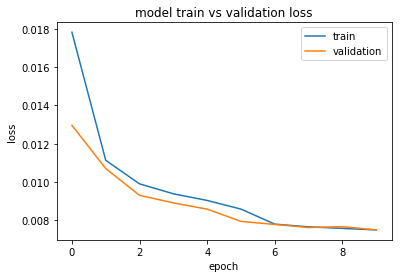

In [111]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [112]:
emb.save('embedding.h5')

In [113]:
X_ex = np.array([['Jeanne', 'aime', 'Marie'],
                 ['Jeanne', 'voit', 'Marie'],
                ['Pierre', 'tweetait', 'un', 'message'],
                ['Suzanne', 'googlera', 'la', 'réponse'],
                ['Anne',  'est', 'fatiguée']])
X_ex_ci = word_matrix_to_charint_matrix(X_ex, maxChars)
test_prediction = emb.predict(X_ex_ci)

In [114]:
def display_pred(X_ex, test_prediction, minprob):
    word_counter = 0
    # iterate over sentences
    for i in range(len(X_ex)):
        # iterate over words
        for j in range(len(X_ex[i])):
            print(X_ex[i][j], end = ': ')
            # iterate over word features
            for k in range(len(test_prediction[word_counter])):
                if test_prediction[word_counter][k] > minprob:
                    print(integer_to_feature[k], end = ' ')
            print('')
            word_counter = word_counter + 1



In [115]:
categories = set(['v', 'n', 'nc', 'adj'])
tenses = set(['S', 'P', 'K', 'J', 'T', 'F', 'C', 'I', 'Y2s', 'Y1p', 'Y2p', 'G', 'W'])
person = set(['1', '2', '3'])
number = set(['s', 'p'])
gender = set(['m', 'f'])

def best_inflection(feats, tenses, feature_to_integer, beta):

    maxp = 0
    maxinfl = None
    for t in tenses:
        tnum = feature_to_integer[t]
        prob = feats[tnum]
        if prob > maxp:
            maxp = prob
            maxinfl = t
    cutoff = maxp * beta
    result = {}
    for t in tenses:
        tnum = feature_to_integer[t]
        prob = feats[tnum]
        if prob > cutoff:
             result[t] = prob
                
    return maxinfl, result

In [116]:
display_pred(X_ex, test_prediction, 0.5)

Jeanne: nc s f 
aime: 1 nc Obj:sn s P v Y2s S 3 
Marie: s f np hum 
Jeanne: nc s f 
voit: Obj:sn s P v 3 
Marie: s f np hum 
Pierre: nc s f 
tweetait: Obj:sn s v 3 
un: nc m s det pro 
message: nc m s 
Suzanne: nc s f 
googlera: Obj:sn s v 3 
la: cla s f det 3 
réponse: nc s f 
Anne: nc s f 
est: nc m s P v AttSuj 3 
fatiguée: K Obj:sn s f active adj Obl2:(par-sn) passive v 


In [ ]:
print(wpm["voit"])
feature_to_integer['Y1s']
print(test_prediction[0][1])

In [120]:
test_word = 15
print(best_inflection(test_prediction[test_word], tenses, feature_to_integer, 0.1))
print(best_inflection(test_prediction[test_word], person, feature_to_integer, 0.1))
print(best_inflection(test_prediction[test_word], number, feature_to_integer, 0.1))
print(best_inflection(test_prediction[test_word], categories, feature_to_integer, 0.1))


('P', {'P': 1.0})
('3', {'3': 1.0})
('s', {'s': 1.0})
('v', {'v': 1.0, 'nc': 1.0})


## Train prefix and suffix vectors

In [84]:
Cutoff = 2

def trim_dict(d, min_count=Cutoff):
    for k,v in list(d.items()):
        if v < min_count:
            del d[k]
    d['*UNK*'] = 1
    d['*OOR*'] = 1
    return d

suffixcount1={}
suffixcount2={}
suffixcount3={}
suffixcount4={}
suffixcount5={}
suffixcount6={}
suffixcount7={}
prefixcount1={}
prefixcount2={}
prefixcount3={}
prefixcount4={}

for word in vocabulary:
    word = word.lower()
    word = re.sub(r'[0-8]', '9', word)
    suf1 = word[-1:]
    suf2 = word[-2:]
    suf3 = word[-3:]
    suf4 = word[-4:]
    suf5 = word[-5:]
    suf6 = word[-6:]
    suf7 = word[-7:]
    pref1 = word [:1]
    pref2 = word [:2]
    pref3 = word [:3]
    pref4 = word [:4]
    
    if len(suf1) > 0:
        if suf1 not in suffixcount1:
            suffixcount1[suf1] = 1
        else:
            suffixcount1[suf1] += 1

    if len(suf2) > 1: 
        if suf2 not in suffixcount2:
            suffixcount2[suf2] = 1
        else:
            suffixcount2[suf2] += 1

    if len(suf3) > 2: 
        if suf3 not in suffixcount3:
            suffixcount3[suf3] = 1
        else:
            suffixcount3[suf3] += 1

    if len(suf4) > 3: 
        if suf4 not in suffixcount4:
            suffixcount4[suf4] = 1
        else:
            suffixcount4[suf4] += 1

    if len(suf5) > 4: 
        if suf5 not in suffixcount5:
            suffixcount5[suf5] = 1
        else:
            suffixcount5[suf5] += 1
    if len(suf6) > 5: 
        if suf6 not in suffixcount6:
            suffixcount6[suf6] = 1
        else:
            suffixcount6[suf6] += 1
    if len(suf7) > 6: 
        if suf7 not in suffixcount7:
            suffixcount7[suf7] = 1
        else:
            suffixcount7[suf7] += 1
    if len(pref1) > 0:
        if pref1 not in prefixcount1:
            prefixcount1[pref1] = 1
        else:
            prefixcount1[pref1] += 1

    if len(pref2) > 1:
        if pref2 not in prefixcount2:
            prefixcount2[pref2] = 1
        else:
            prefixcount2[pref2] += 1

    if len(pref3) > 2:
        if pref3 not in prefixcount3:
            prefixcount3[pref3] = 1
        else:
            prefixcount3[pref3] += 1
    if len(pref4) > 3:
        if pref4 not in prefixcount4:
            prefixcount4[pref4] = 1
        else:
            prefixcount4[pref4] += 1


suffixcount1 = trim_dict(suffixcount1)
suffixcount2 = trim_dict(suffixcount2)
suffixcount3 = trim_dict(suffixcount3)
suffixcount4 = trim_dict(suffixcount4)
suffixcount5 = trim_dict(suffixcount5)
suffixcount6 = trim_dict(suffixcount6)
suffixcount7 = trim_dict(suffixcount7)

prefixcount1 = trim_dict(prefixcount1)
prefixcount2 = trim_dict(prefixcount2)
prefixcount3 = trim_dict(prefixcount3)
prefixcount4 = trim_dict(prefixcount4)

suffix1 = set(suffixcount1.keys())
suffix2 = set(suffixcount2.keys())
suffix3 = set(suffixcount3.keys())
suffix4 = set(suffixcount4.keys())
suffix5 = set(suffixcount5.keys())
suffix6 = set(suffixcount6.keys())
suffix7 = set(suffixcount7.keys())

prefix1 = set(prefixcount1.keys())
prefix2 = set(prefixcount2.keys())
prefix3 = set(prefixcount3.keys())
prefix4 = set(prefixcount4.keys())


In [86]:
print(prefix2)

{'gh', 'ôt', 'iz', 'ss', 'ig', 'le', 'de', 'xi', 'vê', 'ro', 'hi', 'mc', 'ob', 'g9', "s'", 'rè', 'sè', 'cf', 'jo', 'eg', 'bo', 'ké', 'pt', 'ba', 'ae', 'ir', 'vm', 'al', 'âp', 'xx', 'tô', 'xv', 'cè', 'rp', 'ot', 'hl', 'ff', "l'", 'my', 'âg', 'gé', 'ér', 'sd', 'ac', 'sr', 'ds', 'tf', 'tê', 'a-', 'ry', 'vu', 'bb', 'ni', 'pé', 'ag', 'jé', 'os', 'pô', 'cv', 'ex', 'eq', 'bl', 'kl', 'ay', 'dj', 'au', 'a9', 'où', 'él', 'gê', 'ye', "n'", 'en', 'ip', 'ph', 'vr', 'gr', 'qg', 'gi', 'ca', 'cg', 'ax', 'ul', 'pv', 'mn', 'po', 'fg', 'da', 'sp', "c'", '9e', 'tb', 'eb', 'né', 'zé', 'rf', '-c', 'gm', 'av', 'do', 'he', 'kn', 'vl', 've', 'fi', 'bn', 'm9', 'iv', 'ap', 'py', 'ia', 'im', 'ej', 'pm', 'fn', 'ui', 'yv', 'ma', '9-', '*OOR*', 'sa', 'gy', 'ga', 'sh', 'ti', '-i', 'mé', 'ze', 'pn', 'éc', 'ed', 'el', 'ub', 'hé', 'kr', 'sf', 'hâ', 'cn', 'tu', 'fê', 'km', 'pr', 'in', 'dî', 'ab', 'lo', 'nu', '99', 'st', 'op', 'ak', 'mê', 'uc', 'zi', 'ts', 'of', 'yo', 'te', 'cy', 'pâ', 'vv', 'lè', 'îl', 'mp', 'rm', '-l', 

In [87]:
p1_to_integer, integer_to_p1 = indexify(prefix1)
p2_to_integer, integer_to_p2 = indexify(prefix2)
p3_to_integer, integer_to_p3 = indexify(prefix3)
p4_to_integer, integer_to_p4 = indexify(prefix4)

s1_to_integer, integer_to_s1 = indexify(suffix1)
s2_to_integer, integer_to_s2 = indexify(suffix2)
s3_to_integer, integer_to_s3 = indexify(suffix3)
s4_to_integer, integer_to_s4 = indexify(suffix4)
s5_to_integer, integer_to_s5 = indexify(suffix5)
s6_to_integer, integer_to_s6 = indexify(suffix6)
s7_to_integer, integer_to_s7 = indexify(suffix7)


In [88]:
print(p1_to_integer)

{'d': 1, 'â': 2, 'k': 3, 'f': 4, 'p': 5, 'i': 6, 'à': 7, 'ô': 8, '°': 9, 'g': 10, 'x': 11, 'c': 12, 's': 13, 'e': 14, 'v': 15, 'a': 16, 'b': 17, 'z': 18, '*OOR*': 19, 'î': 20, '*UNK*': 21, 't': 22, 'ê': 23, 'm': 24, 'q': 25, '(': 26, 'ç': 27, '-': 28, 'w': 29, 'n': 30, '9': 31, "'": 32, 'u': 33, 'j': 34, '.': 35, 'é': 36, 'r': 37, 'h': 38, 'o': 39, 'l': 40, 'y': 41}


In [146]:
def word_to_prefvec(word, alen, afset, af_to_int):
    if len(word) >= alen:
        pref = word[:alen]
        if pref in afset:
            int = af_to_int[pref]
        else:
            int = af_to_int['*UNK*']
    else:
        int = af_to_int['*OOR*']
    return to_categorical(int, len(afset)+1)


In [147]:
def word_to_sufvec(word, alen, afset, af_to_int):
    if len(word) >= alen:
        pref = word[-alen:]
        if pref in afset:
            int = af_to_int[pref]
        else:
            int = af_to_int['*UNK*']
    else:
        int = af_to_int['*OOR*']
    return to_categorical(int, len(afset)+1)



In [148]:
def word_to_prefix_vector(word):
    p1 = word_to_prefvec(word, 1, prefix1, p1_to_integer)
    p2 = word_to_prefvec(word, 2, prefix2, p2_to_integer)
    p3 = word_to_prefvec(word, 3, prefix3, p3_to_integer)
    p4 = word_to_prefvec(word, 4, prefix4, p4_to_integer)
    return np.concatenate((p1,p2,p3,p4))

def word_to_suffix_vector(word):
    s1 = word_to_sufvec(word, 1, suffix1, s1_to_integer)
    s2 = word_to_sufvec(word, 2, suffix2, s2_to_integer)
    s3 = word_to_sufvec(word, 3, suffix3, s3_to_integer)
    s4 = word_to_sufvec(word, 4, suffix4, s4_to_integer)
    s5 = word_to_sufvec(word, 5, suffix5, s5_to_integer)
    s6 = word_to_sufvec(word, 6, suffix6, s6_to_integer)
    s7 = word_to_sufvec(word, 7, suffix7, s7_to_integer)
    return np.concatenate((s1,s2,s3,s4,s5,s6,s7))

def word_to_affix_vector(word):
    p1 = word_to_prefvec(word, 1, prefix1, p1_to_integer)
    p2 = word_to_prefvec(word, 2, prefix2, p2_to_integer)
    p3 = word_to_prefvec(word, 3, prefix3, p3_to_integer)
    p4 = word_to_prefvec(word, 4, prefix3, p4_to_integer)
    s1 = word_to_sufvec(word, 1, suffix1, s1_to_integer)
    s2 = word_to_sufvec(word, 2, suffix2, s2_to_integer)
    s3 = word_to_sufvec(word, 3, suffix3, s3_to_integer)
    s4 = word_to_sufvec(word, 4, suffix4, s4_to_integer)
    s5 = word_to_sufvec(word, 5, suffix5, s5_to_integer)
    s6 = word_to_sufvec(word, 6, suffix6, s6_to_integer)
    s7 = word_to_sufvec(word, 7, suffix7, s7_to_integer)
    return np.concatenate((p1,p2,p3,p4,s1,s2,s3,s4,s5,s6,s7))

In [149]:
word_to_prefix_vector('Jean')

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [150]:
word_to_affix_vector('Jean')

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [151]:
def compute_affixes(vocab):
    
    word_to_suffix = {}
    word_to_prefix = {}

    for word in vocab:
        w = word.lower()
        w = re.sub(r'[0-8]', '9', w)
        pvec = word_to_prefix_vector(w)
        print(w)
        svec = word_to_suffix_vector(w)
        word_to_prefix[word] = pvec
        word_to_suffix[word] = svec
        
    return word_to_prefix, word_to_suffix    

In [152]:
word_to_prefix, word_to_suffix = compute_affixes(vocabulary)

gâtées
savez
coût
préconisant
ratissage
démarche
niedenhoff
combinat
solde
999
déjeune
recherche
cafés
patients
pluie
implantations
accuse
999
ue
maladetta
gagnant
étranglez
annuels
financées
fondées
raffiné
fourmi
clérical
perraudin
99,999
99.999
9.999
approuve
envoyée
prioritairement
jimmy
brothers
impression
hanson
99
orsay
tour
sbf
relèvement
commuait
vulgairement
auto-allumage
atteintes
gagnait
viable
dédouané
facilités
duménil
pouvant
non
perdurer
intervenue
routiers
99,9
réapprovisionne
noir
dominicaine
9.999,99
cacheux
999.999
adoptent
fiat
verrerie
général-beuret
déconvenue
porcs
inconfortable
accepter
calculés
affecte
cow-boys
autoriserait
urss
oaci
sellier
thoraciques
naviguent
saverne
chausser
exploité
croisement
999
aussi
mathématique
puy-de-dôme
triboulottes
faibli
services
tari
dm
casse
dom
qatargas
management
rencontrées
9999
9.999
bourg-saint-maurice
conclu
faussé
prétendre
délocalisations
paradoxes
99
orienter
invisible
peines
gross
boîtes
simone
descendante
brosse
am

robe
explication
majestueusement
-elles
total
chaude
palestinien
révolutions
polytechnicien
ivoiriennes
apanage
échangent
ena
9,99
sole-99
régaler
retraitement
francs
télécom
court
bientôt
9999
9999
surchargé
impopularité
taïwanaises
n99-99
dépassaient
9999
respire
promener
raconte
lease-back
médiévale
lien
vénézuélienne
différentes
télématique
époustouflant
sanguine
courses
signatures
fédérales
jure
habituer
sncf
contrairement
physionomie
acceptable
next
stricto
révélé
peter
farouchement
nickelodeon
pharmaceutique
déterminante
sut
mois
fétiche
prévenait
bonifiés
9.999
avaliser
schlesinger
bananes
croyances
agiter
décontractée
escarpées
animés
purement
aligné
considérables
cournot
havilland
retardé
9,99
doucement
comparaissent
félicitant
pressée
magistère
applaudir
sauter
999
retransmise
limited
9,9
cuivre
tir
plaisanté
structurante
descendants
nobles
bourse
pub
repartait
lyon-turin
redoutable
permettra
9999
tournée
patrons
résistance
chimique
oubliait
algérien
9999
vide
international


concluent
marriott-prince-de-galles
productifs
puis
linéaires
complices
côtières
comptable
incarcération
respecté
rejoint
couleurs
crapahuté
rapportant
forain
salariaux
parlaient
rod
suffisent
certificats
composante
pavel
monte
coûts-bénéfices
999
technologiques
crénelés
quittons
permirent
salariat
préférerait
puces
99.999
arrivez
coûté
conteur
multimédia
traverse
retrouvez
dépendant
9999
sofil
commercer
9999
reebok
vigoureusement
pipe
terres
flotter
bière
avant-coureur
appétit
irradie
99
modérés
fixait
rétorquent
f-999a
nain
pharmacologiques
deutschen
inflationniste
contentieux
soucieuse
médicaux
confederation
hommage
chomage
déceptions
décrite
propriété
rebâtie
dividendes
échafaudées
cachées
donnée
surréaction
répétitifs
saoudienne
99.999
999
zenit
courageuse
relâchement
limite
parvenir
réajustant
cravates
dépanneur
réévaluation
perthois
intelligence
tranquillement
accounting
syntec
cèderait
alimenté
colbert
universelles
industrielles
coopèrent
verticale
création
champignons
veuves
a

terrorisme
floride
fortement
collecte
newspaper
fressoz
viennent
gilson
réalisées
lutherie
vraiment
précautions
hérissé
tardera
laissait
messier
plaines
interpréta
brisée
carnets
tata
99,99
susciter
infléchissement
crédits
grande
nullement
impression
délivrés
entières
troublantes
999
variété
memoria
possibilités
casser
grenoble
analogues
999,99
décentralisées
affaibli
assurée
walibi
statistiquement
guarda
originaires
limites
dépendantes
déprimé
pro
perpignan
accusent
nicholls
soixante-sept
embellies
99.999
six
traducteurs
avant-scène
barreau
pla
gec
déroulé
cessation
arithmétiquement
9999
lynchage
pavé
variées
coalition
amérique
africains
prévenu
rizzoli
indigence
rome
promulgue
pérol
catimini
confédérale
machine-outil
cgpme
conditions
hénin
99,99
999
rapprochement
sous-traitant
coïncide
astrophysique
remède
fédération
accélérée
tanzanie
acclimater
litige
tragique
persuader
accomplie
caillaou
surveillance
-ce
manifestations
alduy
naval
appuyé
décrivait
record
raisonner
universitaires
é

forteresse
boudé
discorde
rencontrent
boutet
999,9
démontre
allaitante
aiguiser
bonne
parvenue
renouvellements
évident
feint
mais
généralise
am
insupportables
panoplie
océan
désastreuses
défaveur
cliente
oic
volubile
vaclav
axe
précédentes
rotterdam
tchad
éradiqué
enviables
charmer
réau
espoirs
valenciana
999
deutsches
hasan
réagi
999
proscrire
débandade
entraîneur
façons
999,99
onuso-américaine
confronté
camp
força
aequo
donnèrent
dessous
continentales
bousculer
entretenue
precise
rapide
cataplasme
lever
approcha
souffle
maintenir
sentiers
envisagent
indirectes
divergences
révât
bergerac
détournement
peluche
glissés
levaux
possèdent
chiffre-clé
sombres
récoltes
ultrasophistiqué
avive
médiatiser
picade
rachid
célibataire
démutualisation
9.999.999
saône-et-loire
passagère
reconnaît
philanthropie
essaient
réindexer
défini
soixante-dix
999999
999
petroleum
bonasses
languir
chômés
mandaté
renchérit
multiplication
secouée
first
condoléances
affirmés
agissant
prévisible
chaath
exsangue
effic

deficiency
gêner
ibrahim
dramatiques
baroud
ancrées
encourir
jacobs
plaques
nivel
conseiller
débarquent
joueurs
leclerc
simples
pekin
associative
provisions
vitrines
images
relevons
apparitions
dépenses
formes
commerciale
répudie
réservoir
achats
parachute
habitation
sociologue
wirschaft
fatalisme
élus
dépit
base
indispensable
kilos
vivront
révèle
favoriser
bonbel
textile
polyvalent
poursuivaient
interdisent
ramant
corruption
diff.
viêtnam
sollicité
potager
merveilleux
999999
opportunistes
trouvaille
affectées
pme
9,99
grâces
leenhardt
dizaines
mont
prédécesseurs
9.999
salvador
remplaçaient
universitaire
ours
berthold
exorcismes
cohérente
approvisionner
fusionnant
bruges
feront
instituant
envisagé
coeur
séance
coquilles
commercialiser
progressiste
installé
autocollants
schneider
allocations
extérieurs
rituel
pierrejean
retraitée
fou
bradage
compenser
aujourd'hui
apprennent
tranquilliser
faulx
rejetées
antenne
voltigeurs
ig-metall
nationales
stratégies
céleste
touriste
italie
ôtent
999


mézenc
expriment
entités
répondant
lancer
tombe
accolé
déficit
majoré
chalmin
états-unis
technicien
entreprenante
bannie
nairas
flammes
viens
multimédias
convaincus
999.999
airbus
contestable
perturbées
covent
gavarnie
transport
fiables
sucre
intéressante
robusta
ferroviaire
indicatif
costumes
écran
thouvenel
bain
9999-9999
industrialisée
fortunés
9999
spécialiste
9.999
chargeurs
stratégiques
couverture
bourses
arrêts
argile
pamplemousse
songent
aps
industrialisation
cesse
privilégiées
nancéien
empêtrée
tassement
sochaux-montbéliard
établis
conçues
habillage
pascal
99,9
vêtements
indiens
tragédies
all
allen
9999
promotionnelle
serres
nuisances
9,99
vissé
location
signet
rogatoire
délai
théâtres
excuse
defense
rediffusion
aiguë
teillol
quarante-quatre
multitude
samsung
temps
que
999.999
notaires
enchaînements
incarcérés
pêcheurs
unilever
toutes
oslo
partager
soucie
saint-louis
critiquant
aeritalia
usagers
jordanie
cimenteries
risquait
agitée
diriger
9,9
jury
lorrains
lufthansa
talents
b

mesguish
falloir
chin-feun
paris-montsouris
jules-romains
milhaud
partisane
limelight
avocate
avait
kier
cim
urgence
réactions
cicatrice
idyllique
formait
subdivision
9999
taïwanais
contraignant
independant
ténu
9999
insignifiant
leon
amorphe
ifop
9.999
passion
réticents
écharpe
réclament
cadavres
passée
999,9
tombée
compétents
pousser
jet
fdp
mises
incendiées
sous-estimer
simulation
déconnecter
payaient
dominé
99,9
passerait
régionale
mineures
indifférent
ployé
seuil
ouest
assombrissent
assurerions
autant
parafiscales
étouffante
socle
individuellement
hôtel
proportionnel
cautionné
opérées
égyptienne
gendarme
thérapeutiques
combats
détenue
ébauchée
crédit-relais
mineur
températures
psychologiques
programmes
reçus
mouvance
régnera
esthétisme
percevra
personnes
va
catholique
participations
ordonnance
dégradations
rétrécissement
aube
reprocher
mériter
nicolaï
seine-saint-denis
voyageurs
éloquents
soumis
refusant
invitant
pierluigi
999
mocassins
demeurent
expert-comptable
vaincre
sublime
a

diversification
ribéry
bas
franc-maçonnerie
industrie
accompagnement
notes
cuirs
bouche-à-oreille
rattrapage
durée
opposent
généralisée
tardieu
planter
smirnoff
relancent
regroupera
catalogués
impliquée
propria
front
prospectent
9.999.999
effectuer
fokker-999
veillée
universités
confiseurs
direction
9999
routinière
accéder
popiwek
bokassa
privilégierait
radonet
hi-fi
étalon-boeuf
atr
très
999
sabeg
obsédés
erik
réattribué
9.999
spécialisée
999
verrouillé
abordions
anita
artisans
groupée
seize
espèces
exceptionnel
9999
mobilise
frontaliers
moissac
vendaient
cnpa
constituées
crevasses
propension
tantôt
descendent
enclenché
perigot
sirven
lourd
wagram
steinkühler
thaïlande
repos
pugilat
ressaisie
distincts
confiné
vrai
articule
sepp
renseigner
marionnette
cristal
péruviennes
évoluera
punta-del-este
isabelle
grincheux
nourriture
power
finition
fédérale
état
vif
sculpteur
99e
quatrième
agent
endiguée
moniteurs
singes
ados
urgent
99,9
9,99
autofinancement
9999
manifestaient
éradiquer
ce9
cré

autorisation
primo
voiturin
aritmos
réalisent
multipliés
anomalie
poussait
créée
intensifiée
faille
magique
utilisant
avancer
cadeau
teissier
émules
automobil'
caisses
joaillerie
apposée
fabrications
sorti
constatent
regroupés
frange
extrait
boisson
enchaîné
monti
première
relayés
journaliste
quasi
rassemblement
équivaut
détaillé
validées
pèlerins
pu
électriciens
communiste
cala
favorisée
ore
législative
colombiennes
application
catalogue
confondent
eurosceptiques
répondrait
colombie
étrangère
vois
maux
engagent
9,9
europ-assistance
arnaud
recharger
la
plaidoirie
désirs
métaux
résume
debt
estimations
traumatisent
cambriolé
téléfilm
gênant
deir-ez-zor
cherchant
goût
chômé
jawa
phares
trottinettes
mini
efficaces
9999-9999
revêt
décidément
prétendaient
cristallisé
endettés
verticalement
grandissante
parisien
manient
aegon
initiation
déformé
dévoré
provoquées
9.999
dénoncées
conjoncturelle
excavations
armée
fortifier
soixante
continueront
eysymontt
aztèques
honneurs
émetteur
hors
conforter

envoyé
9999
croupes
volumes
comédien
accessibilité
abidjan
nord-américaines
affaiblis
hany
irréductibles
épargnée
moscou
laissé
antienne
fluidité
veillerait
amateur
estompe
lombard
mesures
majeure
neutralité
rarement
déversent
complètes
quadrature
länder
daté
cuba
défendent
oxbridge
léotard
mobilisaient
restaurent
relativement
chaudes
satisfont
piscines
9999
aimais
veine
argentines
henning
mythes
parcmètres
trente-et-une
hall
provençale
papeteries
lanceur
effectuaient
nabil
perdus
instrument
lesur
aufbruch
conçus
rasséréner
différente
minimales
armateurs
désindustrialise
catégories
dominée
galeuses
malraux
délégatif
gardien
autorisée
convulsions
vaut
file
servant
imposent
transferts
mirecurtiens
tarissement
impuissante
contre-attaque
raisonnement
gouvernent
riens
mercredi
evreux
berlin-est
rémunératrices
99,99
raffinés
subi
999
ballet
navire
concrétise
suzanne
dgse
cementos
quelques
déposées
parcs
entendent
minérales
surplus
rater
laisserait
échappant
jetbus
ivresse
bâtiment
tuffier
ol

viktor
déroulées
colis
zielona-gora
ltd.
crises
revus
spectacles
confondues
imaginez
cartier
selette
pilotes
himalaya
électorales
il
engagées
hold-up
câblées
toyota
multilatéral
esthétique
9999
j'
col
9,999
étatique
proviendraient
julien
explosé
critiquent
egor
torts
énorme
réajuste
faillir
manifestées
contraintes
succédera
sud-américains
lis
cotisations
révisée
langueur
999
9.999
rideau
sfh
souvenir
saints
effractions
chèques-vacances
gironde
lundi
flancs
message
mort
documentaires
joueur
travel
99
comptabilité
économiste
organisant
eglise
sampermans
barbe
rationnel
insuffisant
approfondissement
pénibilité
supposons
.
fantasmes
rejettent
pluriannuelle
urwald
scribe
découvrimes
préconisons
ledoucin
ans
capables
exhaustif
bosch
feu
implosion
resserrant
excès
999
bianco
repartager
inoxydables
inversée
tricotant
orzo
fidèle
quadriller
recrutements
repassa
9999
timidité
engraisse
essuie
dépression
smoby
marquer
celle-ci
niveau
parlement
eurodollar
évitons
préside
tisser
sumitomo
spd
rauco


atteindrait
promenaient
suchard
concerneront
because
passaient
inquiets
hôte
hygena
convertis
fille
guérilleros
créancier
vsd
assauts
réhabiliter
courtes
hagarde
canon
arranger
roland
levier
lorgnent
xiaoping
précipitamment
voulut
interférométrique
traces
hélicoptère
conteste
commenceront
accru
georgyi
conformismes
évertué
restreindre
symbolise
son
bourgoin-jallieu
plongeant
frémi
cabine
irlande
rejoignez
communication-développement
chaperon
législateur
souciant
hirudines
alarmants
renouvelée
conçu
promulgation
9999
lapidaire
rhône-alpes
relégation
performance
portillo
economiquement
mont-saint-martin
comédie-française
indécis
as
démontrer
passer
je
9,99
agrégat
séparatisme
figurent
quatre
obligatoires
andreotti
arrêter
moitié-moitié
999,9
renoncé
comptabilisée
999
diplomate
audit
libératoire
déprime
disposée
interrogée
999
consacrent
longs-métrages
comparé
gueules
investments
mnr
demandeurs
abondantes
courra
arbitral
correspondance
bataillon
annonçaient
données
enterrée
gourmand
conse

bonifie
g.o.
n9
subites
distillées
troc
suspend
trompe
salam
probablement
entraide
mensongère
biélorussie
reliefs
confidences
téléphonie
exigeront
mont-cenis
achevée
épargnants
sami
débordements
baccarat
réciproques
météorologiques
libraires
vge
attira
cette
attraction
écrivant
hip-hop
achètera
guérison
balance
vigne
foot
bankers
dessinent
perversions
droits
équateur
aura
incitation
diagnostic
saint-paul
arithmétiques
pamplemousse
v.
venu
désigné
postérité
prisonnier
russe
autorisèrent
oie
secondaires
idéale
montures
etam
salamandre
madame
clearing
]
passera
étalée
promet
sacrés
mortel
séances
asnl
branche
999,9
thatcher
latifundio
soviétiques
dénationalisations
apparemment
cobalt
9,9
projection
contrepartie
enseignements
distribuées
franchissez
charmant
cession
débarqué
publicité
rentre
surprise
conclusions
département
concurrente
finlandaise
préceptes
illégales
là
orlyval
cyclomoteurs
choquées
tendant
avoisiné
élargissant
chacun
amendé
fusionnent
schreiner
conseillers
utah
999
sarreb

périscolaire
équiper
passablement
document
perpendiculaire
redonne
négocierait
côtés
conduisent
accordés
israélien
montent
colombes
99
und
docks
°
9999
grosser
elisa
développeur
condottieri
indiscutablement
adjuge
fougueux
soleil
précédemment
toute
dépaysement
9,99
prélevée
tablant
considérés
emmenthal
cauterets
99,9
dresdner
handicapé
dirigez
franchise
contactera
plc
maximum
norvégien
inventeur
formulées
grosrichard
transporta
inculpés
mécanicien
jalousies
dispositions
gage
9999
retrouvait
félicite
démarrer
continu
amèrement
sar
objectera
sentiments
divise
après
tamisés
signé
reconduite
anglo-saxonnes
9999
diète
poétiquement
mirages
clouait
campan
apurés
touchant
nets
catégorie
négociées
soupapes
justification
zahidi
trente-huit
disparaîtra
calamités
bourges
révélés
clandestines
caillots
portail
poto-poto
optent
9,9
vidé
réticences
99,99
weber
diester
anticipations
devenus
exil
funkoverload
pkk
chants
impact
agefi
albin
affiné
eut
travailleurs
desktop-iv
contrôlant
reconstitution
sous

9.999
agissait
arguer
égalée
comparée
télévisé
normandin
immergés
minier
norias
octopussy
dégrisement
9.999
renseignera
congrès
étonner
port
atout
cadarache
article
militaristes
guerry
dépasser
breton
kombou
poserait
ne
différée
99999
lantra
biologique
loyer
baisserons
crise
tirait
métallurgique
attendais
guitton
abaissement
concurrentiel
radio-france
guestier
tribunal
annule
parfums
familiales
employé
cependant
décidée
mallette
norman
propager
coronarien
régulièrement
danoise
rééquilibrage
désire
meilleures
valorisée
lacombe
bts
indistinctes
raisins
relèvent
soigne
magistères
kevin
charriés
censure
abondants
empiètement
9,99
présomptions
croissance
débordante
hosni
reculs
majesté
gâte
après
influence
réitèrent
épine
bleu-verte
99.999
sligos
devises
moteur
four
999999
franco-allemand
lampe
99.999
delphine
fustigé
rebondir
décote
opposés
chaotique
cordillère
pérouse
rendue
saisonniers
salon
coutume
m9
occupée
quadrichromie
9999
norbert
rassembler
hollywoodiens
passons
jointes
dauzier
ré

9ème
essai
coal
lenoir
99999
sévérité
heurté
nancéiens
unique
expédition
maghrébins
redise
merchant
éco-bilan
sociologie
poincaré
gagnerait
reculé
scrupuleux
bilatéraux
paix
passive
atrophie
pape
pack
tentative
f
bousquet
près
laos
9999
élucider
réaliste
files
pensais
prologue
renforcerait
revêtement
hussein
totalise
brèves
99,9
perpétuera
décharges
copropriété
bri
invasions
parabolique
9,99
fournirait
99.999
fachinetti
rendus
paroisse
californien
enserrée
manufacturière
pénal
olympiques
fleurir
procédaient
dictature
99,9
perte
vive
masure
recensement
plaies
worth
charles-emile
présent
imprévu
fête
refluer
canalisations
augmenté
comportée
alcool
rentrés
impératif
9
9.999
montai
astrologie
rompra
replacer
orale
fiente
dessinée
console
appartenue
rhodium
saemes
existants
stockée
alourdit
resté
genevoise
tandis
remaniement
affectionnait
krzysztof
immunité
sacrifice
lagardère
provocateur
regardez
gagnent
bibliographiques
millénaire
californiens
dasa
gattegno
plier
chipie
vêtir
progressive


situait
pourvoir
volume
attali
managers
versement
audincourt
dépendre
dispose
mérites
amicale
bijouterie
présentateurs
bruxelles
9,9
dix
fréquent
définitivement
rire
illustrant
baur
sauces
incendies
lasser
all
design
descente
électorale
publient
répugnent
picorer
poindre
télé
aggravent
ressemblaient
protégés
présentées
aimée
refusent
illustrations
distinction
quatre-vingt-quatorze
agités
worsred
erreur
9.999
emmener
abandonnaient
sartilly
sanofi
cône
cm³
privilégier
couteau
traduites
affût
richier
exclurait
sas
terry
irak
9999
michelin
irrespect
berliner
mémoire
obligent
99,9
fous
lugano
99,9
atteignant
accrédite
redoutant
9999
klippan
soulèvements
déconcentration
fontaine
maraîchers
rapprochent
autrement
lorraines
prolifération
honda
rousset
alimentés
elkabbach
héritage
produit
paternalisme
tête-défense
reverser
jacobins
bénévoles
favorables
contrôlés
pures
9,999
appartiendrait
grimpait
99999
retenu
frustrés
poliet
barbieux
chènes
9,99
publicis
ferrata
sainte-honorine
arabis
extractio

fertiles
djakarta
ouest-allemandes
dégarnis
oeuvre
possession
anathèmes
affichait
géographique
repète
morris
splendide
999
withdraws
examinées
établi
valses-hésitations
vver
rendez-vous
page
démarquer
reclasse
majorés
monnaie
avignon
desdits
9,9
bouillonnement
nombreux
écot
99.999
gestner
indépendants
sephi
corrige
internationales
feutrées
coqueluche
9,99
air-bag
frappée
disparates
chatouillant
prospèrent
réveillera
9,99
aides
perles
anticipation
mis
décharger
plaint
commencent
amélie
intra-
transports
toujours-plus
paramètres
trouva
9,99
controversée
dram
devis-type
écueil
toises
éloquentes
partenariats
économiquement
paroissiaux
gatt
centralement
fusil
envoyant
recula
navrée
initiales
dela
finesse
perspectives
serrer
jean-michel
rafraîchi
enseignement
impliqué
allègements
supposer
détention
comparer
élaborée
ces
cylindre
chapelle
exorcisons
bluff
99,9
injecter
assurément
washingtonien
apparences
storebrand
or
agression
manifestement
9,99
parvenant
orientant
projet
empressement
délici

rossinot
prône
voyager
redouter
devance
dieulouard
spéculative
pioneer
new-hampshire
émancipation
savoir-faire
versées
99,9
gilles
crampes
ligne
9999
relève
commercial
ruset
sentiront
poignée
world
game
préjugés
picard
mairie
germaniques
adressent
généralisation
volets
ghosn
enchaîné
décidaient
sous-évalués
ing
conclure
mobis
hôpital
pierrefitte
99
polynésie
mandataires
seul
absolu
paillettes
9,9999
proposeront
contenaient
hôtes
dassault-aviation
représenter
profond
tel-aviv
itcf
radioastronomie
casier
inquiétaient
morvillars
incongrue
aigu
thyssac
procureur
pif-gadget
volent
pots-de-vin
similaire
autoroute
équipé
manques
suscitent
craquement
qualités
déposants
peton
9,9
abîmes
tableau
anonymes
apogée
bras
priori
9.999
locataires
écourte
dalton
suivrait
étais
souain
triste
successeurs
bilatérale
999
magny-cours
kazakhstan
perestroika
effet
changerait
par-dessus
defossez
praticiens
entouré
promoteurs
agha
99,9
exponentielle
constants
dominguez
emparant
basketteur
iconoclastes
nouveaux
c

altitude
figure
bolloré
bourreau
accroîtra
sabatier
99,9
australie
motif
broadcasting
garantissant
km
méridien
marquant
brent
génération
noté
australo-argentin
manglou
inachevé
représentativité
9,99
fabrication
kahloon
grange
colloque
remarquai
ténues
sidérurgique
référendaire
encadrés
999.999
conspirationniste
réembauches
togo
criminelles
habituelle
gendarmerie
publications
plus
mode
menacé
nanterre
wilson
commercialisation
traversées
cryptées
acquitté
bûches
servis
abn
apprivoisée
protection
banalisé
capital
valréal
ressoude
siemens
canailles
contre-pouvoir
immobiliers
heilbronner
convivialité
999,9
tandis
coupons
vie
regroupent
ukrainienne
lapins
vazquez
9.999,99
if
déjà
aix-en-provence
honneur
déduction
champion
neutre
spectaculaires
défiance
emporter
vous
remarque
999.999
géométrie
rivalisent
lâcher
assister
inexistante
flots
indo-pakistanais
signalement
bit
9,99
déploraient
tente
9,9
plénière
vingt-deux
plaidoiries
concepteur
stagnent
fractions
marqués
évêque
organismes
aix-les-b

hans
subissait
visiteurs
reprendront
expliquer
lalitte
revendiquent
assouplies
9.999
serveuses
opposait
standard
bovin
riche
lenticulaire
bactériologie
tf
publications
tes
bank
structurelles
élégant
charmantes
cache
9999
solidarité
riante
acceptent
guardian
aimé
fabiani
borislav
diplomatie
abusivement
dates
patronat
gael
paroxysme
approvisionnements
salinité
balfour
incombent
soulignant
sécurisante
99999
éventuelle
annuler
protestants
mjc
surqualifiés
trouveront
copropriétaires
découragement
999.999
9,9
émissions
identités
douloureux
fs
accusée
simplifiée
enlevées
garantie
enthousiaste
érigé
99,99
raffinements
bouclage
poursuivons
dont
asiatique
fetese
confirmée
confus
judicieuse
préservés
survint
pressé
chargements
fini
attacher
km9
tirent
reprendra
blanc
nike
outillage
réservée
reconnaissant
journée
999.999
wonder
tranchées
niel
fabriqué
néthou
fusionner
chalands
provision
commerces
exprime
salomon
huchon
éveil
fictions
temps
simmermann
légaux
trains
yvelines
usage
9
perdre
gbm.h
nou

In [153]:
print(np.argmax(word_to_sufvec('Coût', 3, suffix3, s3_to_integer)))

906


In [154]:
print(integer_to_s3[906])

oût


In [155]:
print(word_to_suffix_vector('Jimmy'))

[ 0.  0.  0. ...,  0.  0.  0.]


In [144]:
print(np.argmax(word_to_sufvec('jimmy', 1, suffix1, s1_to_integer)))

IndexError: index 41 is out of bounds for axis 1 with size 41

In [145]:
print(suffix1)

{'d', 'k', 'f', 'p', 'ë', 'ù', 'i', 'à', '°', 'g', 'x', 'c', 's', 'e', 'v', 'a', 'û', ')', 'ï', 'z', 'b', '*OOR*', '*UNK*', 't', 'm', 'q', '-', 'w', 'n', '9', "'", 'u', 'j', '.', 'é', 'l', 'r', 'o', 'h', '!', 'y'}
